# Twitter Sentiment Analysis of COVID-19 in the state of Virginia

## Introduction
The United States is in disarray. It started with the onset of COVID-19, an extremely contagious respiratory virus with an estimated mortality rate of 3-4% according to the World Health Organization.  The rate for at-risk populations—elderly, and those with underlying conditions such as heart disease, diabetes, asthma, etc.— is much higher. Much of the country is shut down, and on March 30, 2020 Virginia Governor Ralph Northam declared a stay-at-home order until June 10th. States across the country are grappling to design a testing and tracing infrastructure before opening the economy back up. Opinions on how and when to reopen the country are varied.

The COVID-19 pandemic is going to have long-lasting impacts on our public health, economy, and way of life. From the dramatic increase in unemployment to the subsequent loneliness and depression caused by social distancing measures, the mental health impact of COVID-19 will be substantial. For my Capstone project, I am using Twitter data from Virginia to track daily sentiment toward the virus (and stay-at-home measures) as the virus travels through the state. The goal of this project is to create an auxiliary surveillance tool for the Virginia Department of Health (DOH) that uses social media data to track sentiment towards COVID-19 and the stay-at-home measures in place.

## Public Health Surveillance using Twitter Data
“Health organizations require accurate and timely disease surveillance techniques in order respond to emerging epidemics. Such information may inform planning for surges in patient visits, therapeutic supplies, and public health information dissemination campaigns.” (Broniatowski, Paul & Dredze, M, 2013.). However, real-time data collection is very expensive and simply not feasible for most organizations.  As such, ongoing research continues into using social media for real-time disease and health surveillance.

Using social media data for public health surveillance is not a new idea, and in fact the Center for Disease Control and Prevention (CDC) has been using Twitter for influenza surveillance for almost a decade. The goal of this project is not to necessarily use Twitter data to estimate COVID-19 prevalence using the frequency of COVID-related Tweets as the CDC has done with influenza surveillance, though I will look to see if COVID sentiment leads or lags reported cases. The goal is broadly exploratory, aiming to monitor sentiment towards the virus and the stay-at-home measures by time and location. In addition to highlighting areas in which sentiment is particularly low (and potentially triggering investigation by the VA DOH), the idea is to set up a framework for the VA DOH to use Twitter for surveillance for the remainder of the COVID lifespan. Right now, we are looking at stay-at-home measures, but when things reopen it could be identifying COVID resurgence hot spots (via text frequency or sentiment), or measuring response towards the vaccine once available.

## Assessing Spikes in Twiter Sentiment Over Time
The whole point of my project is to see if a Twitter Covid Sentiment Score could be used for public health surviellence. Ideally, we could use the DSS (Daily Sentiment Score) to identify and locate emerging problems/issues accross the state as we reopen the economy, and work to establish the "new normal."

This notebook is to specifically address Twitter data from days in which DSS spiked positively or negatively.


In [970]:
import re,string
import nltk

from pprint import pprint
import pandas as pd
import numpy as np
import os
import matplotlib
import functools
from functools import reduce

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as pyplt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import multiprocessing
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
import sklearn.linear_model 

from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import spacy

# Plotting tools
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

RANDOM = 36 # To be reproducible

# set working file
os.chdir('/Users/rachelmartonik/MSDS_498_Capstone/data')

# Data

I am pulling daily data from the Twitter application user interface (API) using the rtweet package in R. Data collection is limited to tweets posted in Virginia according to Twitter. Two daily pulls are run:

    1.	COVID pull that uses the search terms: #COVID, COVID, COVID-19, #COVID-19, coronavirus, and #coronavirus. Data collection started April 7th.
    2.	Stay-at-home pull that uses the search terms: #stayhome, #stayathome, #Quarantine, quarantine, and #SocialDistancing. Data collection started April 9th.



In [996]:
daily_sentiment_VA = pd.read_pickle("daily_sentiment_VA_final.pkl")
daily_sentiment_VA

,frequency,Day_of_Collection,Date,Sentiment_Score,dow,week,day_type,day_type_num
0,49194,1,4/7,0.081293,Tues,1,Weekday,1
1,47847,2,4/8,0.074978,Wed,1,Weekday,1
2,45651,3,4/9,0.090639,Thurs,1,Weekday,1
3,41537,4,4/10,0.094334,Fri,1,Weekday,1
4,29042,5,4/11,0.027994,Sat,1,Weekend,2
5,24927,6,4/12,0.040572,Sun,1,Weekend,2
6,39581,7,4/13,0.077544,Mon,2,Weekday,1
7,42231,8,4/14,0.089263,Tues,2,Weekday,1
8,42962,9,4/15,0.071433,Wed,2,Weekday,1
9,42669,10,4/16,0.079084,Thurs,2,Weekday,1


In [1022]:
# Select sentiment spike days
daily_sentiment_VA_spikes = daily_sentiment_VA[((daily_sentiment_VA['Day_of_Collection'] ==13) | \
                                                (daily_sentiment_VA['Day_of_Collection']==14) | \
                                                (daily_sentiment_VA['Day_of_Collection']==44) | \
                                                (daily_sentiment_VA['Day_of_Collection']==48) | \
                                                (daily_sentiment_VA['Day_of_Collection']==29))]
daily_sentiment_VA_spikes

,frequency,Day_of_Collection,Date,Sentiment_Score,dow,week,day_type,day_type_num
12,25605,13,4/19,-0.000853,Sun,2,Weekend,2
13,36791,14,4/20,0.061912,Mon,3,Weekday,1
28,32616,29,5/5,0.114890,Tues,5,Weekday,1
43,26704,44,5/20,0.066504,Wed,7,Weekday,1
47,15982,48,5/24,0.002376,Sun,7,Weekend,2


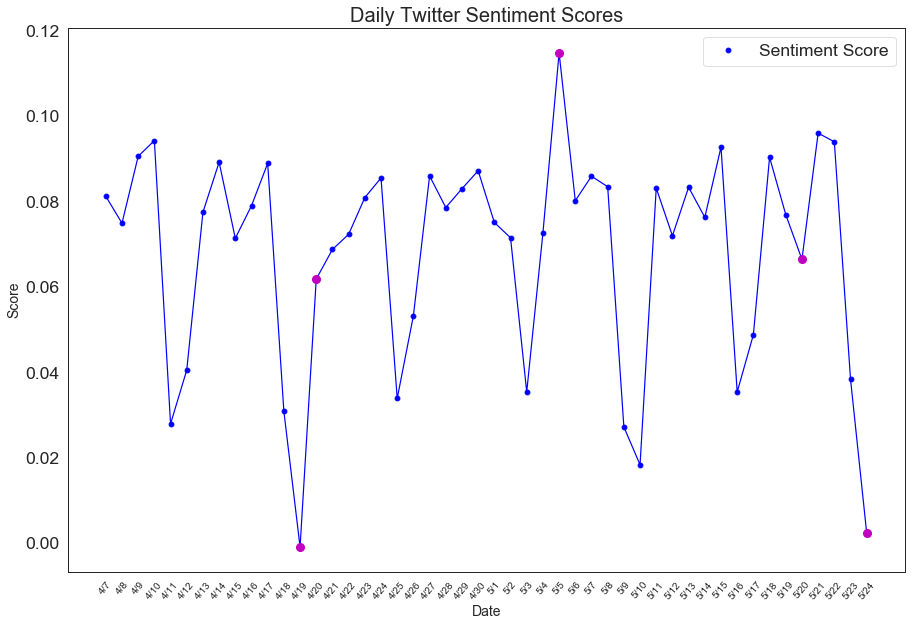

In [1023]:
import matplotlib.pyplot as plt

Date = daily_sentiment_VA['Date']
Sentiment = daily_sentiment_VA['Sentiment_Score']

Date_spikes = daily_sentiment_VA_spikes['Date']
Sentiment_spikes = daily_sentiment_VA_spikes['Sentiment_Score']

# "bo" is for "blue dot"
plt.figure(figsize=(15, 10))
plt.plot(Date, Sentiment, 'bo', label='Sentiment Score')
plt.plot(Date, Sentiment, 'b')
plt.plot(Date_spikes, Sentiment_spikes, 'o', color="m", markersize=8)
# b is for "solid blue line"
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Daily Twitter Sentiment Scores', size=20)
plt.xlabel('Date', size = 14)
plt.ylabel('Score', size = 14)
plt.xticks(rotation=50, size=10);
plt.legend()
plt.savefig("DSS-Overall", tight_layout=False)

plt.show()

## April 19
What happened on __Sunday 4/19__ and __Monday 4/20__ ??? Why did sentiment drop?

The percentage of the Tweets that mention Donald Trump in some capacity is negatively correlated with sentiment with a Pearson’s r of -0.654 statistically significant with a p-value of <.001. See figure below.

Twelve percent of the Tweets on 4/19 mention Trump—which is the third highest day—and comes on the heels of Trump’s controversial 4/17 Tweets about “liberating states” on lockdown, including Virginia:

    “LIBERATE VIRGINIA, and save your great 2nd Amendment. It’s under siege!,” 

Anecdotal evidence suggests the response to Donald Trump over a weekend with fewer Tweets overall and general lower sentiment scores caused this dip.


## May 5
What happened on __Tuesday 5/5__??? Why did sentiment spike?
    - See analysis below - Giving Tuesday day of action: https://www.givingtuesday.org/blog/2020/03/givingtuesday-announces-day-global-action-giving-and-unity-response-covid-19
 
What happened on __Wednesday 5/20__??? Why did sentiment drop?

What happened on __Sunday 5/24__??? Why did sentiment drop?


In [1098]:
trump_stats = pd.read_csv("trump_counts.csv")
trump_stats.head()

,date,Trump,Not,Total,% Trump
0,4/7/20,3770,316,4086,0.077
1,4/8/20,3731,287,4018,0.071
2,4/9/20,3541,244,3785,0.064
3,4/10/20,3176,228,3404,0.067
4,4/11/20,1953,192,2145,0.090


In [1099]:
daily_sentiment_VA = pd.concat([daily_sentiment_VA, trump_stats], axis=1)
daily_sentiment_VA

,frequency,Day_of_Collection,Date,Sentiment_Score,dow,week,day_type,day_type_num,date,Trump,Not,Total,% Trump,date,Trump,Not,Total,% Trump
0,49194,1,4/7,0.081293,Tues,1,Weekday,1,4/7/20,3770,316,4086,0.077,4/7/20,3770,316,4086,0.077
1,47847,2,4/8,0.074978,Wed,1,Weekday,1,4/8/20,3731,287,4018,0.071,4/8/20,3731,287,4018,0.071
2,45651,3,4/9,0.090639,Thurs,1,Weekday,1,4/9/20,3541,244,3785,0.064,4/9/20,3541,244,3785,0.064
3,41537,4,4/10,0.094334,Fri,1,Weekday,1,4/10/20,3176,228,3404,0.067,4/10/20,3176,228,3404,0.067
4,29042,5,4/11,0.027994,Sat,1,Weekend,2,4/11/20,1953,192,2145,0.090,4/11/20,1953,192,2145,0.090
5,24927,6,4/12,0.040572,Sun,1,Weekend,2,4/12/20,1697,214,1911,0.112,4/12/20,1697,214,1911,0.112
6,39581,7,4/13,0.077544,Mon,2,Weekday,1,4/13/20,3008,292,3300,0.088,4/13/20,3008,292,3300,0.088
7,42231,8,4/14,0.089263,Tues,2,Weekday,1,4/14/20,3209,280,3489,0.080,4/14/20,3209,280,3489,0.080
8,42962,9,4/15,0.071433,Wed,2,Weekday,1,4/15/20,3285,265,3550,0.075,4/15/20,3285,265,3550,0.075
9,42669,10,4/16,0.079084,Thurs,2,Weekday,1,4/16/20,3221,266,3487,0.076,4/16/20,3221,266,3487,0.076


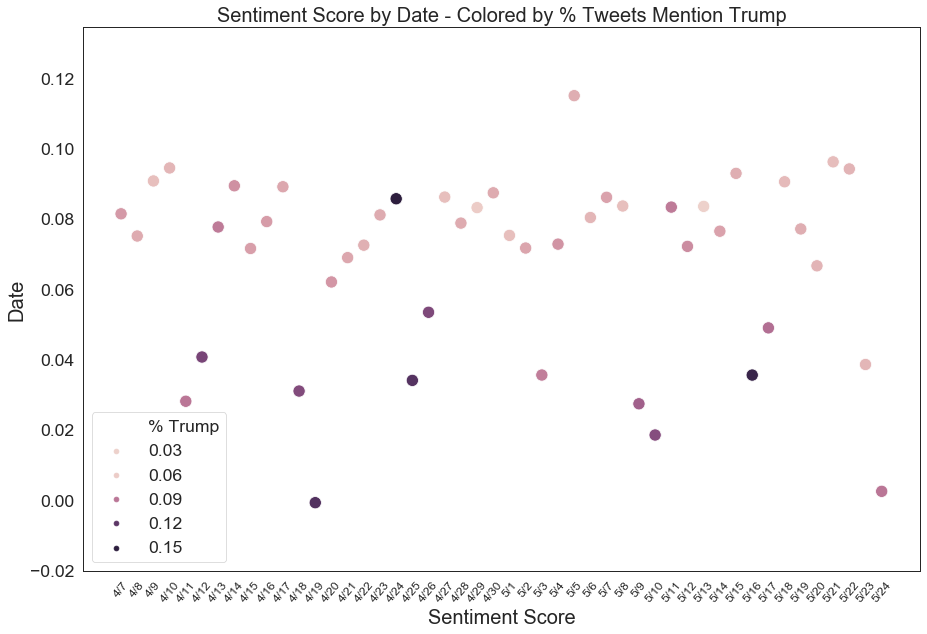

In [1094]:
# Daily Sentiment Score by Date - Colored by day type
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="% Trump",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Date - Colored by % Tweets Mention Trump",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.xticks(rotation=50, size=12);
plt.legend()
plt.savefig("DSS-by_Trump", tight_layout=False)
plt.show()

In [1097]:
corr, pvalue = pearsonr(daily_sentiment_VA['% Trump'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)

0.00000046597994109025
Pearsons correlation of reported cases and Sentiment Score: -0.654


## Reviewing Tweets from Specific Day

In [985]:
# Read in final cleaned data from Captsone Analysis
merged_cleaned_data = pd.read_pickle("merged_cleaned_data_final_200527.pkl")

In [1104]:
# Identify date for review
#data_0419_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-04-19']
data_0520_clean = merged_cleaned_data[merged_cleaned_data['X1']=='2020-05-20']

In [1105]:
#data = data_0505_clean
data = data_0520_clean
len(data)

2296

In [1106]:
#create list of all texts for cleaning
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Create function to run sentiment analysis
def sentiment_score(data):
    text_body=[]
    
    for i in range(0,len(data)):
        temp_text=data['text'].iloc[i]
        text_body.append(temp_text)
    
    analyzer = SentimentIntensityAnalyzer()
    sentences = text_body

    sentiment_score = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        sentiment_score.append(vs)
    
        a = pd.DataFrame(sentiment_score)
    #df = pd.concat([a, text_body_df], axis=1)
    return a

In [1107]:
# Run sentiment scoring function with current data
sent = sentiment_score(data)

In [1108]:
#create list of all texts for cleaning
text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

In [1109]:
data_county = pd.DataFrame(data["county_name"])
data_county.reset_index(inplace=True)

In [1110]:
df = pd.concat([sent, text_body_df], axis=1)
len(df)

2296

In [1111]:
df = pd.concat([data_county, df], axis=1)
df.sort_values(by="compound")

,index,county_name,neg,neu,pos,compound,text
520,28515,montgomery county,0.691,0.309,0.000,-0.9867,. #Lockdown4 @FoxNews @CNN The Trump plan for reelection &amp; coronavirus: Confuse. blame and undermine blame and undermine confuse blame and undermine blame and undermine confuse blame and undermine blame and undermine. blame and undermine blame and undermine
2029,45233,essex county,0.562,0.406,0.031,-0.9820,@LBC Well it is but illegals who may have criminal records and coronavirus never 😡😱😱😱
1848,43283,fairfax county,0.389,0.554,0.058,-0.9815,"@Reuters @phildstewart @idreesali114 U.S Navy itching for a war as if all the wars engaged in all over the planet &amp; war against Covid not enough! Not known how many soldiers stricken with Covid on all her warships. Poised for war everywhere incl S. China Sea! War, killing &amp; conflict U.S way of life! Jesus leading?"
2220,48618,charlottesville city,0.326,0.674,0.000,-0.9674,@waltshaub @katertomater This is more than a regular election for republicans. They must hang onto control in White House and Senate. So this will be a death match. This covid crisis is the disaster and shock they’ve been waiting for to impose authoritarian corporate capitalism on America. Death match.
1843,43237,norfolk city,0.310,0.690,0.000,-0.9608,@DPWIMM @DanRather It's your body and if you get covid 19 it's your problem but you don't have the right to put others at risk with your selfishness. Grow up kid!!You voted for a liar.That tells me that you are a liar and a bad person!!!
...,...,...,...,...,...,...,...
740,30790,charlottesville city,0.000,0.610,0.390,0.9608,"THANK YOU! Last week’s Drive-In show raised $60,111 for @_MealsOnWheels and we appreciate your generosity. Tune in tonight for #DMBDriveIn and please support our spotlight charity for this episode, @Spotify COVID-19 Music Relief Project and more specifically, @musichealthall. https://t.co/v0Hzvqr25u"
343,26830,alexandria city,0.000,0.676,0.324,0.9622,"For a short time, the Big ""I"" Virtual Legislative Conference is FREE and on-demand. 4 quick 45 minute segments will get you up to speed on the election, COVID-19, legislative issues and more. We also celebrate our amazing award winners. \nRegister today! https://t.co/l6xFGARgXs https://t.co/tjsVBhNkPU"
1451,38374,richmond city,0.000,0.725,0.275,0.9632,"The James River Family Dentistry team is smiling and grateful to serve YOU! 💙 We look forward to seeing you at your next dental visit with us! 😄 Also, be sure to visit our website to learn what we are doing to protect you and the team from COVID-19. 👍🏼 #JRFD #Blessed https://t.co/LlpljGBgko"
355,26905,roanoke city,0.000,0.628,0.372,0.9633,"You can join Dana in supporting Friendship as we ensure all our residents and team members are healthy and safe during this pandemic. Register to run, walk, or take 19 other steps of kindness May 27-June 2, and help us Outpace COVID-19: https://t.co/33Rjkvim5d #outpacecovid19 https://t.co/d1koATZKUt"


In [1112]:
#what are hashtags of the data?
data["hashtags"].value_counts()

Covid_19                                        30
coronavirus                                     26
COVID19                                         24
COVID                                           7 
Coronavirus                                     5 
                                               .. 
abcmeritshopproud construction covid19          1 
community homelessness coronavirus              1 
coronavirus president WillSmith                 1 
InfectionPrevention covid19 nursingeducation    1 
LibertyUniversity Virginia                      1 
Name: hashtags, Length: 608, dtype: int64

In [1114]:
df.compound.describe()
# 4/19 had an overall score of .-0.0007853 - very low
# 5//20 had an overall score of  0.066504  - very low for weekday


count    2296.000000
mean     0.066504   
std      0.496350   
min     -0.986700   
25%     -0.296000   
50%      0.000000   
75%      0.476700   
max      0.995900   
Name: compound, dtype: float64

In [1115]:
df2 = df[['county_name', 'compound']]
df3 = pd.DataFrame(df2.groupby('county_name')['compound'].mean())
df4 = pd.DataFrame(df2.groupby('county_name')['compound'].count())
df3.sort_values('compound')

,compound
county_name,
carroll county,-0.757300
orange county,-0.743000
galax city,-0.704600
northumberland county,-0.585900
accomack county,-0.521500
pittsylvania county,-0.456700
appomattox county,-0.442767
amelia county,-0.440400
shenandoah county,-0.437150


In [1116]:
df5 = pd.merge(df3, df4, on='county_name')
df5.columns=['sentiment', 'freq']
df5.sort_values(by="sentiment")

,sentiment,freq
county_name,,
carroll county,-0.757300,1
orange county,-0.743000,1
galax city,-0.704600,2
northumberland county,-0.585900,1
accomack county,-0.521500,1
pittsylvania county,-0.456700,2
appomattox county,-0.442767,3
amelia county,-0.440400,1
shenandoah county,-0.437150,2


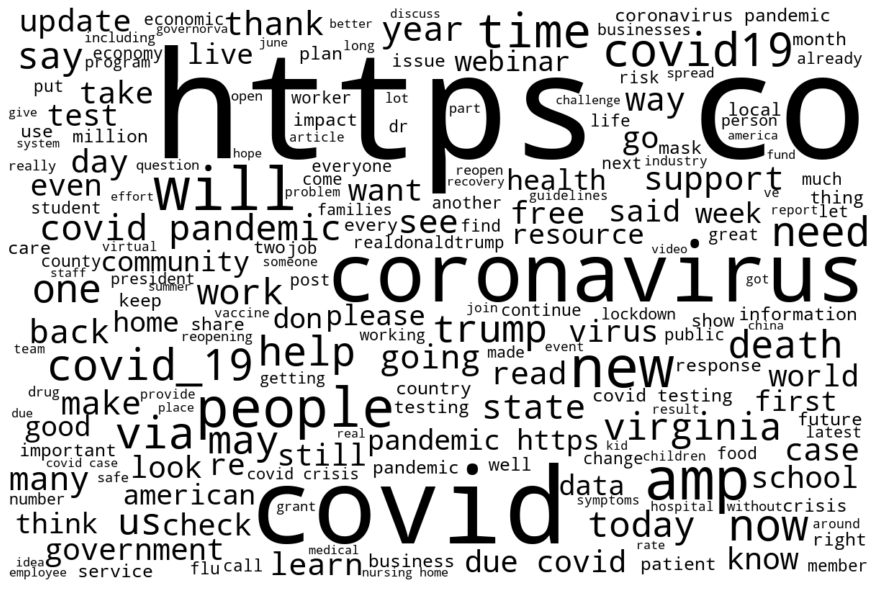

In [1117]:
#### Word cloud ####
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = ' '
stopwords = set(STOPWORDS) 
 
# iterate through the csv file 
for val in data.text:      
   # typecaste each val to string 
   val = str(val) 
   # split the value 
   tokens = val.split()     
   # Converts each token into lowercase 
   for i in range(len(tokens)): 
       tokens[i] = tokens[i].lower() 
         
   for words in tokens: 
       comment_words = comment_words + words + ' '
# words should all be same color and horizonal 
wordcloud = WordCloud(width = 1200, height = 800, 
               background_color ='white', 
               stopwords = stopwords,prefer_horizontal=1, color_func=lambda *args, **kwargs: "black",
               min_font_size = 10).generate(comment_words) 

# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('th.png')
plt.show() 


In [1034]:
from nltk.collections import Counter
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()
tokenized_sents = [tokenizer.tokenize(i) for i in text_body]
#for i in tokenized_sents:
    #print (i)

In [1035]:
# Create a vocabulary document
import functools 
from functools import reduce
tokenized_sents = reduce(lambda x, y: x + y, tokenized_sents, [])

vocab = Counter(tokenized_sents)
print(len(vocab))
#vocab.most_common()

12969


# Compare top words in different sets of Tweets

In [1065]:
data = data_0423_clean

In [1066]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 250  # set vector length for TF-IDF and Doc2Vec

In [1067]:
# Process the data
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # Manually clean equivalent classes  
    # # filter out stop words
    stop_words = list(stopwords.words('english'))            
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens



text_body=[]
for i in range(0,len(data)):
    temp_text=data['text'].iloc[i]
    text_body.append(temp_text)
    
text_body_df = pd.DataFrame(text_body)
text_body_df.columns=['text']

processed_text=[]
# Process documents
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)
    

final_processed_text=[]
# Combine for final processed text list
for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    

In [1068]:
# Check out most frequent words in cleaned data
tokenizer = TreebankWordTokenizer()
tokenized_sents = [tokenizer.tokenize(i) for i in final_processed_text]
tokenized_sents = reduce(lambda x, y: x + y, tokenized_sents, [])

vocab = Counter(tokenized_sents)
print(len(vocab))
vocab.most_common()

12042


[('coronavirus', 992),
 ('covid', 538),
 ('amp', 264),
 ('pandemic', 256),
 ('us', 249),
 ('people', 239),
 ('new', 214),
 ('via', 209),
 ('help', 166),
 ('health', 165),
 ('get', 149),
 ('trump', 140),
 ('one', 130),
 ('like', 125),
 ('time', 124),
 ('home', 117),
 ('know', 114),
 ('need', 114),
 ('virginia', 111),
 ('cases', 106),
 ('crisis', 105),
 ('would', 102),
 ('see', 102),
 ('work', 102),
 ('make', 100),
 ('support', 99),
 ('care', 98),
 ('may', 97),
 ('today', 96),
 ('read', 92),
 ('go', 88),
 ('business', 88),
 ('day', 87),
 ('due', 87),
 ('deaths', 87),
 ('many', 86),
 ('states', 86),
 ('testing', 85),
 ('still', 85),
 ('response', 85),
 ('news', 82),
 ('patients', 82),
 ('even', 82),
 ('could', 81),
 ('first', 81),
 ('well', 80),
 ('keep', 78),
 ('going', 77),
 ('virus', 74),
 ('world', 72),
 ('great', 72),
 ('workers', 72),
 ('good', 70),
 ('take', 70),
 ('impact', 70),
 ('think', 69),
 ('way', 69),
 ('working', 67),
 ('times', 67),
 ('back', 67),
 ('learn', 67),
 ('stay'

In [1072]:
# Pull out Tweets with #GivingTuesdayNow to see if that is what is causing sentiment to spike
data_0419_clean['Trump'] = data_0419_clean['text'].str.contains('trump', case=False).astype(str)
data_0419_clean.Trump.value_counts()

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


False    1704
True     226 
Name: Trump, dtype: int64

In [1100]:
# Get count/percentage of daily Tweets that mention Trump
searchfor = ['trump', 'president', 'presidenttrump', 'Trump', 'realdonaldtrump', 'donald trump']
merged_cleaned_data['Trump'] = merged_cleaned_data['text'].str.contains('|'.join(searchfor), case=False)
merged_cleaned_data.head()

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,X1,X2,location_cleaned,county_name,Trump
36534,x17503420,x1247640716366544896,2020-04-07 21:41:41,JonKatz5,"""How to Protect Your Mental Health During the Coronavirus""- Emily Esfahani Smith https://t.co/mTFX8yblMp",Twitter for iPhone,104,NaN,NaN,NaN,...,http://katzjustice.com/Blog,NaN,https://pbs.twimg.com/profile_banners/17503420/1433068923,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/634152687718699008/lvkSZGYh_normal.jpg,2020-04-07,21:41:41,fairfax virginia,fairfax county,False
36971,x1108447003154022401,x1247672670969303041,2020-04-07 23:48:40,DrLucyHenshall,#Annie #Tomorrow \n#community #singing #Covid_19 \nJoin us 8pm Thursday doorsteps\n@Clive_Harris @Annie_Osb @suffolkgiving @TimHolder11 @balletboy09 @Jochurchill4 @sarsHQ @MarkGlennMurphy @nikkijfox https://t.co/plIW1DJWxc,Twitter for iPhone,195,NaN,NaN,NaN,...,NaN,NaN,https://pbs.twimg.com/profile_banners/1108447003154022401/1553118284,NaN,http://pbs.twimg.com/profile_images/1150730378103205888/CGBKP0cX_normal.jpg,2020-04-07,23:48:40,suffolk,suffolk city,False
36973,x1108447003154022401,x1247630744480026624,2020-04-07 21:02:03,DrLucyHenshall,https://t.co/OYVXzv6a7K via @YouTube\nThink we found our 8pm Thursday evening choirmaster\n#Covid_19 #community #singalong\n@RobBaskind @ClareGerada @DrSdeG @alexandra_DBmed @EM_HealthPsych @AmandaCHoweRCGP @helenamckeown @medicsupport @NikkiKF @fhussain73 @ArtfulDoctor\n@MartinRCGP,Twitter for iPhone,279,NaN,NaN,NaN,...,NaN,NaN,https://pbs.twimg.com/profile_banners/1108447003154022401/1553118284,NaN,http://pbs.twimg.com/profile_images/1150730378103205888/CGBKP0cX_normal.jpg,2020-04-07,21:02:03,suffolk,suffolk city,False
37086,x833159137554989056,x1247634578862485505,2020-04-07 21:17:18,JCarrollFoy,"We now have over 400,000 Virginians covered by Medicaid. We need healthcare coverage now more than ever. The COVID-19 tests may be free but the life saving care &amp; treatment required if you have it is not. https://t.co/XPtWr5JOKt",Twitter for iPhone,208,NaN,NaN,NaN,...,https://www.jennifercarrollfoy.org/,NaN,https://pbs.twimg.com/profile_banners/833159137554989056/1547320826,NaN,http://pbs.twimg.com/profile_images/1188107942119260161/N4IgFVtA_normal.jpg,2020-04-07,21:17:18,woodbridge va,prince william county,False
38014,x54078897,x1247651532503420929,2020-04-07 22:24:40,AndrewAlixRadio,"Crazy to think, if not for coronavirus, we all would have been in New Orleans this past weekend watching Virginia Tech play in the Woman’s Final Four.",Twitter for iPhone,150,NaN,NaN,NaN,...,https://podcasts.apple.com/us/podcast/hokie-hangover/id1478134982,NaN,https://pbs.twimg.com/profile_banners/54078897/1543304041,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1145505359278354432/chFBKHrB_normal.jpg,2020-04-07,22:24:40,blacksburg virginia,montgomery county,False


In [1101]:
# For times sake, I just copied this into Excel to format and get percentages
trump_counts = merged_cleaned_data[['X1', 'Trump']]
trump_counts.groupby('X1').Trump.value_counts()

X1          Trump
2020-04-07  False    3770
            True     316 
2020-04-08  False    3731
            True     287 
2020-04-09  False    3541
            True     244 
2020-04-10  False    3176
            True     228 
2020-04-11  False    1953
            True     192 
2020-04-12  False    1697
            True     214 
2020-04-13  False    3008
            True     292 
2020-04-14  False    3209
            True     280 
2020-04-15  False    3285
            True     265 
2020-04-16  False    3221
            True     266 
2020-04-17  False    3266
            True     252 
2020-04-18  False    1897
            True     233 
2020-04-19  False    1693
            True     237 
2020-04-20  False    2782
            True     234 
2020-04-21  False    2932
            True     229 
2020-04-22  False    2921
            True     217 
2020-04-23  False    3019
            True     232 
2020-04-24  False    2982
            True     462 
2020-04-25  False    1644
            True    

## Cluster the April 19th documents to see if I can figure out what is going on

In [240]:
# Settings for vectorization
STEMMING = False  # judgment call, parsed documents more readable if False
MAX_NGRAM_LENGTH = 2  # Experiment with n-gram length
VECTOR_LENGTH = 250  # set vector length for TF-IDF and Doc2Vec

In [241]:
from nltk.corpus import stopwords

# Function to clean documents
def clean_doc(doc): 
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # Change numbers to words to incorporate years experience
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # # filter out short tokens
    #tokens = [word for word in tokens if len(word) > 1]
    # #lowercase all words
    tokens = [word.lower() for word in tokens]
    # Manually clean equivalent classes
  
    # # filter out stop words
    stop_words = list(stopwords.words('english'))
                   
    tokens = [w for w in tokens if not w in stop_words]         
    # # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens


In [242]:
# Create empty list to store text documents labels (job titles)
labels=[]

#Append job titles to label list
for i in range(0,len(data)):
    temp_text=data['county_name'].iloc[i]
    labels.append(temp_text)

processed_text=[]

# Process documents
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

In [243]:
# Combine for final processed text list
final_processed_text=[]

for i in processed_text:
    temp_DSI=" ".join(str(item) for item in i )
    final_processed_text.append(temp_DSI)
    
type(final_processed_text)
#the following is an example of what the processed text looks like.  
print('\nExample of what one parsed document looks like:\n')
print(final_processed_text[4])


Example of what one parsed document looks like:

economy collapsing republicans blame


In [244]:
df

,index,county_name,neg,neu,pos,compound,text
0,158,frederick county,0.125,0.769,0.106,-0.1027,LFCC nursing alum John Alger leaves for Boston today to join the coronavirus fight. https://t.co/bCND1pIfj6\n#nursing #COVID19 https://t.co/iZeIvGxwSf
1,954,richmond city,0.000,1.000,0.000,0.0000,"David Bowie bassist Matthew Seligman, 64, dies of coronavirus https://t.co/lobzKV30Vf"
2,1738,virginia beach city,0.000,0.899,0.101,0.6486,@SassySculptor @ShawnG927 @NYGovCuomo I’m sure glad Cuomo‘s press conferences are so much more informative on the coronavirus then #RealDonaldTrump pressers. I bet the boyfriend knows the corrupt family he is getting himself into. He knows where the power in money flows. Plus Andrew can introduce him to the Clintons.
3,1862,charlottesville city,0.125,0.653,0.222,0.6996,"The greatest threat by far to our world is #ClimateChange, but the #COVID19 pandemic can provide valuable lessons in restructuring our society and political direction to better deal with the #ClimateCrisis (Hint NO MORE SCIENCE-DENYING AUTOCRATS!) https://t.co/UH8Ido38yK"
4,2028,bedford county,0.247,0.753,0.000,-0.5574,Florida’s economy is collapsing under COVID-19 — and they only have Republicans are to blame https://t.co/E1fPMHw6It
...,...,...,...,...,...,...,...
1925,35022,richmond city,0.000,1.000,0.000,0.0000,4.18.20 White House coronavirus briefing. Trump’s hair was particularly Flock of Seagulls. #asshat #WhiteHousePressBriefing #Covid_19 #OrangeManBad https://t.co/gNMkYCRKXJ
1926,35030,montgomery county,0.200,0.800,0.000,-0.1280,Joe wants to drone strike covid https://t.co/oeJEMZpEFv
1927,35037,newport news city,0.000,1.000,0.000,0.0000,Gematria Effect News on The Color of COVID coming on tonight\n\nhttps://t.co/zwnNEXnQkn
1928,35095,galax city,0.000,0.851,0.149,0.8053,"@LABasedComedian @TheQuartering Clout? He already has 691K subscribers. What clout is there to get? He's doing it cause ppl have went jobless and unemployed because of COVID-19. 3 million ppl are unemployed because of COVID-19. He's doing it to help out. Like he ""Doing whatever I can to help out"""


In [248]:
RANDOM = 36 # To be reproducible
# Create Job Descriptopn labels to use later
job_labels=[]
sent_label=[]

#Append county_name as label
for i in range(0,len(data)):
    temp_text=data['county_name'].iloc[i]
    job_labels.append(temp_text)
    
for i in range(0,len(data)):
    temp_text=df['compound'].iloc[i]
    sent_label.append(temp_text)

['LFCC',
 'nursing',
 'alum',
 'John',
 'Alger',
 'leaves',
 'for',
 'Boston',
 'today',
 'to',
 'join',
 'the',
 'coronavirus',
 'fight.',
 'https',
 ':',
 '//t.co/bCND1pIfj6',
 '#',
 'nursing',
 '#',
 'COVID19',
 'https',
 ':',
 '//t.co/iZeIvGxwSf',
 'David',
 'Bowie',
 'bassist',
 'Matthew',
 'Seligman',
 ',',
 '64',
 ',',
 'dies',
 'of',
 'coronavirus',
 'https',
 ':',
 '//t.co/lobzKV30Vf',
 '@',
 'SassySculptor',
 '@',
 'ShawnG927',
 '@',
 'NYGovCuomo',
 'I',
 '’',
 'm',
 'sure',
 'glad',
 'Cuomo',
 '‘',
 's',
 'press',
 'conferences',
 'are',
 'so',
 'much',
 'more',
 'informative',
 'on',
 'the',
 'coronavirus',
 'then',
 '#',
 'RealDonaldTrump',
 'pressers.',
 'I',
 'bet',
 'the',
 'boyfriend',
 'knows',
 'the',
 'corrupt',
 'family',
 'he',
 'is',
 'getting',
 'himself',
 'into.',
 'He',
 'knows',
 'where',
 'the',
 'power',
 'in',
 'money',
 'flows.',
 'Plus',
 'Andrew',
 'can',
 'introduce',
 'him',
 'to',
 'the',
 'Clintons',
 '.',
 'The',
 'greatest',
 'threat',
 'by',
 'f

In [250]:
######### MATRIX 1 - Count Vectorization using max vocab words #########
MAX_NGRAM_LENGTH = 2
VECTOR_LENGTH=500
count_vectorizer = CountVectorizer(ngram_range = (1, MAX_NGRAM_LENGTH), max_features = VECTOR_LENGTH)
count_vectors = count_vectorizer.fit_transform(final_processed_text)
count_vect_df = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names(), index=sent_label)
count_vect_df.head()

,able,absolutely,across,actually,administration,age,ahead,almost,already,also,...,would,wrong,wtf,year,years,yes,yet,york,youre,youtube
-0.1027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.6486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0.6996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-0.5574,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [251]:
#PCA fucntions of word vectors - with and without labels

# PCA Scatterplot
def princomp_scatter_labels(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (20, 16))
    plt.scatter(result[:, 0], result[:, 1])
    words = list(data['title'])
    for i, word in enumerate(words):
      plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
    plt.show()
    
def princomp_scatter(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1])
    plt.show()

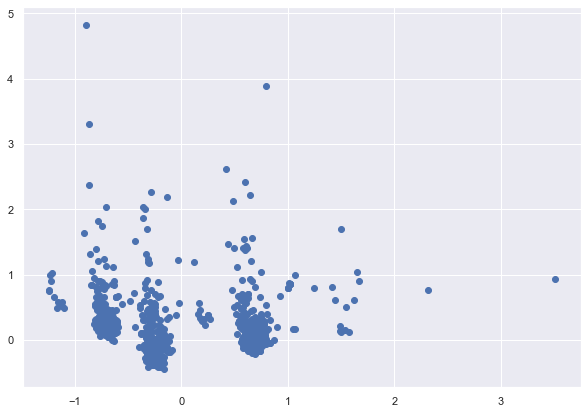

In [252]:
#PCA of count vectorizer
princomp_scatter(count_vect_df) 
#princomp_scatter_labels(count_vect_df)

In [269]:
# Clustering
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
RANDOM = 36

# Skree plot function
def elbow_plot(df, num_clusters):
    wcss = []
    for i in range(1, num_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=RANDOM)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    features = range(1,20)

    plt.plot(features, wcss, '-o', color='black')
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

# Silhouette analysis can be used to determine the degree of separation between clusters.
from sklearn.metrics import silhouette_samples, silhouette_score

def silhouette_samples_viz(df, clust_range):
    for i, k in enumerate(clust_range):
        fig, (ax1) = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
    
        # Run the Kmeans algorithm
        km = KMeans(n_clusters=k)
        labels = km.fit_predict(df)
        centroids = km.cluster_centers_

        # Get silhouette samples
        silhouette_vals = silhouette_samples(df, labels)

        # Silhouette plot
        y_ticks = []
        y_lower, y_upper = 0, 0
        for i, cluster in enumerate(np.unique(labels)):
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            y_upper += len(cluster_silhouette_vals)
            ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
            ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
            y_lower += len(cluster_silhouette_vals)

        # Get the average silhouette score and plot it
        avg_score = np.mean(silhouette_vals)
        ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
        ax1.set_yticks([])
        ax1.set_xlim([-0.1, 1])
        ax1.set_xlabel('Silhouette coefficient values')
        ax1.set_ylabel('Cluster labels')
        ax1.set_title('Silhouette plot for the various clusters', y=1.02);
        
# Function to plot cluster results on PCA map by color
def princomp_scatter_color(vector):
    pca = PCA(n_components=2, random_state=RANDOM)
    result = pca.fit_transform(vector)
    plt.figure(figsize = (10, 7))
    plt.scatter(result[:, 0], result[:, 1], c=kmeans.labels_.astype(float))
    plt.show()
    
# Function to get top 15 words in each cluster - counts
def word_freq_df(dataframe):
    freq = dataframe.sum(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "frequency"})
    print(freq.sort_values('frequency', ascending=False).head(15))
    
# Function to get top 15 words in each cluster - mean
def word_mean_df(dataframe):
    freq = dataframe.mean(axis=0)
    freq = freq.to_frame()
    freq = freq[1:]
    freq = freq.rename(columns={0: "mean"})
    print(freq.sort_values('mean', ascending=False).head(15))

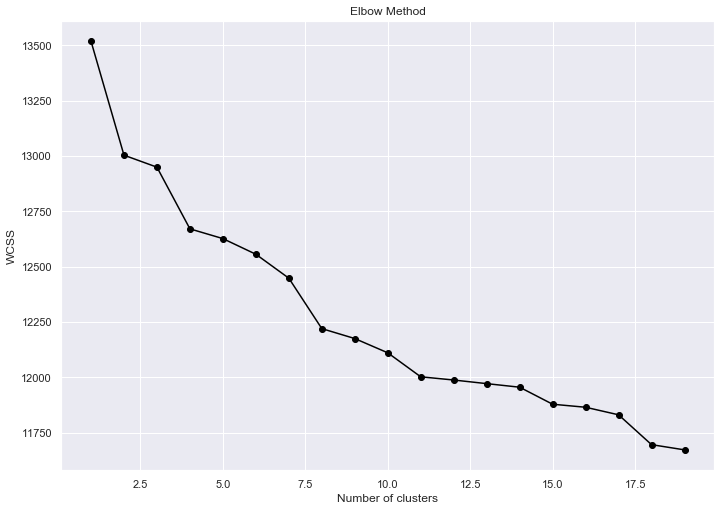

In [254]:
##### Count Vectorizer Elbow Plot #####
elbow_plot(count_vect_df, 20)

In [255]:
# Silhoutte plot
# df = count_vect_df
# clust_range = [2,4,8,11]
# silhouette_samples_viz(df, clust_range)

WCSS: 12670.905025721117


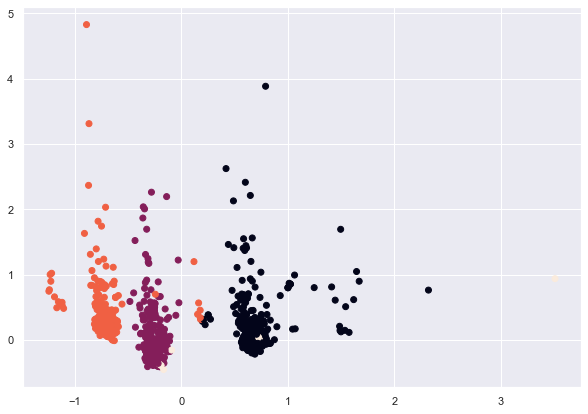

In [256]:
# Cluster Matrix 1 - Count Vectorizer
n_clusters=4
kmeans = KMeans(n_clusters, random_state=RANDOM).fit(count_vect_df)
print('WCSS:', kmeans.inertia_)
labels = kmeans.labels_

princomp_scatter_color(count_vect_df)

In [262]:
# Create dataframe for exploration of clusters
clusters1 = count_vect_df.copy()
clusters1['clusters']= labels #Glue back to original data
clusters1.reset_index(inplace=True)
clusters1 = clusters1.rename(columns={"index": "sentiment"}) # need to get job titles off of index
clusters1["county_name"] = df["county_name"]
clusters1.clusters.value_counts() # Freqency of clusters

1    894
0    681
2    337
3    18 
Name: clusters, dtype: int64

In [266]:
clusters1.groupby('clusters')['sentiment'].mean()

clusters
0   -0.061304
1    0.052327
2   -0.008787
3   -0.199511
Name: sentiment, dtype: float64

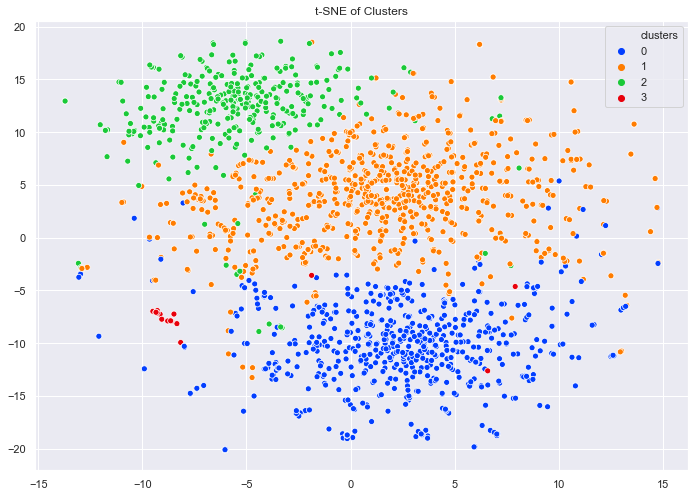

In [258]:
# T-SNE vizualization with clusterung
sns.set(rc={'figure.figsize':(11.7,8.27)})
tsne = TSNE(random_state=RANDOM, learning_rate=150, perplexity=50)
X_embedded = tsne.fit_transform(count_vect_df)
palette = sns.color_palette("bright", 4)
y = clusters1['clusters']
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full', palette=palette).set_title('t-SNE of Clusters')
plt.savefig('tSNE_matrix1.png')

In [270]:
c1

,sentiment,able,absolutely,across,actually,administration,age,ahead,almost,already,...,wtf,year,years,yes,yet,york,youre,youtube,clusters,county_name
0,-0.1027,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,frederick county
1,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,richmond city
2,0.6486,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,virginia beach city
5,-0.2960,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bedford county
6,0.2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,bedford county
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fredericksburg city
1912,0.7003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,richmond city
1913,0.2023,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,alexandria city
1921,0.0000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,fairfax county


In [271]:
# Review the clusters in detail
c1 = clusters1[clusters1['clusters']==0]
counts = c1['county_name'].value_counts()
print(counts / len(c1))
c1_copy = c1.copy()
c1_copy.drop(['sentiment', 'county_name', 'clusters'], axis = 1, inplace=True) 
word_freq_df(c1_copy)

fairfax county           0.139501
richmond city            0.099853
arlington county         0.073421
essex county             0.070485
virginia beach city      0.069016
alexandria city          0.067548
charlottesville city     0.060206
norfolk city             0.042584
loudoun county           0.035242
prince william county    0.026432
newport news city        0.024963
falls church city        0.017621
suffolk city             0.017621
roanoke city             0.013216
isle of wight county     0.013216
culpeper county          0.011747
chesterfield county      0.011747
williamsburg city        0.010279
king george county       0.010279
fredericksburg city      0.010279
lynchburg city           0.010279
manassas city            0.008811
stafford county          0.008811
washington county        0.008811
montgomery county        0.008811
henrico county           0.007342
charlotte county         0.007342
bedford county           0.007342
portsmouth city          0.007342
hanover county

In [272]:
c1.sentiment.describe()

count    681.000000
mean    -0.061304  
std      0.484824  
min     -0.954000  
25%     -0.466000  
50%      0.000000  
75%      0.296000  
max      0.982500  
Name: sentiment, dtype: float64

In [273]:
c2 = clusters1[clusters1['clusters']==1]
counts = c2['county_name'].value_counts()
print(counts / len(c2))
c2_copy = c2.copy()
c2_copy.drop(['sentiment', 'county_name', 'clusters'], axis = 1, inplace=True) 
word_freq_df(c2_copy)

fairfax county           0.147651
richmond city            0.143177
arlington county         0.080537
alexandria city          0.070470
virginia beach city      0.065996
charlottesville city     0.063758
culpeper county          0.033557
norfolk city             0.030201
harrisonburg city        0.026846
essex county             0.024609
suffolk city             0.022371
hampton city             0.022371
loudoun county           0.021253
henrico county           0.016779
prince william county    0.015660
montgomery county        0.014541
roanoke city             0.011186
portsmouth city          0.011186
fredericksburg city      0.010067
charlotte county         0.010067
manassas city            0.010067
lynchburg city           0.010067
stafford county          0.008949
bedford county           0.008949
fauquier county          0.008949
york county              0.006711
falls church city        0.006711
rockingham county        0.006711
hanover county           0.006711
newport news c

In [274]:
c3 = clusters1[clusters1['clusters']==2]
counts = c3['county_name'].value_counts()
print(counts / len(c3))
c3_copy = c3.copy()
c3_copy.drop(['sentiment', 'county_name', 'clusters'], axis = 1, inplace=True) 
word_freq_df(c3_copy)

richmond city            0.154303
fairfax county           0.109792
arlington county         0.097923
virginia beach city      0.094955
essex county             0.077151
charlottesville city     0.056380
alexandria city          0.056380
norfolk city             0.035608
culpeper county          0.032641
loudoun county           0.026706
suffolk city             0.020772
prince william county    0.017804
harrisonburg city        0.014837
chesterfield county      0.014837
montgomery county        0.014837
isle of wight county     0.014837
manassas city            0.011869
henrico county           0.011869
hampton city             0.011869
charlotte county         0.008902
winchester city          0.008902
newport news city        0.008902
lynchburg city           0.005935
orange county            0.005935
roanoke city             0.005935
washington county        0.005935
floyd county             0.005935
falls church city        0.005935
petersburg city          0.005935
fredericksburg

In [275]:
c4 = clusters1[clusters1['clusters']==3]
counts = c4['county_name'].value_counts()
print(counts / len(c4))
c4_copy = c4.copy()
c4_copy.drop(['sentiment', 'county_name', 'clusters'], axis = 1, inplace=True) 
word_freq_df(c4_copy)

alexandria city          0.333333
fairfax county           0.166667
newport news city        0.055556
richmond city            0.055556
lexington city           0.055556
arlington county         0.055556
fauquier county          0.055556
henrico county           0.055556
york county              0.055556
prince william county    0.055556
virginia beach city      0.055556
Name: county_name, dtype: float64
             frequency
new          21       
new york     16       
york         16       
coronavirus  14       
times        8        
death        6        
dies         5        
cause        4        
fox          3        
trump        3        
man          2        
news         2        
god          2        
virus        2        
making       2        


In [276]:
c1.sentiment.describe()

count    681.000000
mean    -0.061304  
std      0.484824  
min     -0.954000  
25%     -0.466000  
50%      0.000000  
75%      0.296000  
max      0.982500  
Name: sentiment, dtype: float64

In [277]:
c2.sentiment.describe()

count    894.000000
mean     0.052327  
std      0.512461  
min     -0.994700  
25%     -0.361200  
50%      0.000000  
75%      0.488450  
max      0.985500  
Name: sentiment, dtype: float64

In [278]:
c3.sentiment.describe()

count    337.000000
mean    -0.008787  
std      0.534632  
min     -0.975300  
25%     -0.476700  
50%      0.000000  
75%      0.458800  
max      0.981700  
Name: sentiment, dtype: float64

In [279]:
c4.sentiment.describe()

count    18.000000
mean    -0.199511 
std      0.502317 
min     -0.980800 
25%     -0.578775 
50%     -0.136600 
75%      0.000000 
max      0.932900 
Name: sentiment, dtype: float64

In [ ]:
# Check to see where the Giving Tuesday Tweets are coming from
a = pd.DataFrame(df.county_name.value_counts()/138)
a.reset_index(inplace=True)
a.columns=['county_lower', 'percent_of_tweets']
a

In [ ]:
county_population = pd.read_pickle('/Users/rachelmartonik/covid/county_population.pkl')
df_population = pd.merge(county_population, a, on='county_lower')
df_population.sort_values('percent_of_tweets', ascending=False)

#GivingTuesday Tweets are coming dispropotionaly from Arlington and Alexandria and Richmond

In [ ]:
# Check to see where overall tweets are coming from compared to population distribution
g = pd.DataFrame(merged_cleaned_data.county_name.value_counts()/len(merged_cleaned_data)) # percent of total tweets
g.reset_index(inplace=True)
g.columns=['county_lower', 'percent_of_tweets']
g


In [ ]:
# Read in coutny population data
county_population = pd.read_pickle('/Users/rachelmartonik/covid/county_population.pkl')
g_population = pd.merge(county_population, g, on='county_lower')
g_population['ratio'] = g_population['percent_of_tweets']/g_population['percent_VA_pop']
g_population.sort_values('ratio', ascending=False)
g_population.to_csv('tweet to pop ration_COVID.csv')

In [ ]:
df.compound.describe()

In [ ]:
plt.figure(figsize=(10, 7.5))
ax = sns.boxplot(df.compound)

In [ ]:
plt.figure(figsize=(10, 7.5))
ax = sns.distplot(df.compound)

In [ ]:
# Check out the most negative tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound')[0:50]

In [ ]:
# Check out the most positive tweets
pd.set_option('display.max_colwidth', -1)
df.sort_values('compound', ascending = False)[0:50]

In [ ]:
a = pd.DataFrame(data_0505_clean['hashtags'].value_counts(dropna=True))
a.sort_values('hashtags', ascending=False).head(100)

In [ ]:
70/len(data_0505_clean) # 2.5% of Tweets on Tuesday had the hashtag #GivingTuesdayNow

# givingtuesdaynow
# GivingTuesday

# it is also teacher appreciation week - see if week sentiment is up

In [ ]:
# Pull out Tweets with #GivingTuesdayNow to see if that is what is causing sentiment to spike
data_0505_clean['GIVING'] = data_0505_clean['hashtags'].str.contains('givingtuesday', case=False).astype(str)
data_0505_clean_GIVING = data_0505_clean[data_0505_clean["GIVING"]=='True']
data_0505_clean_NOGIVING = data_0505_clean[data_0505_clean["GIVING"]!='True']
data_0505_clean_GIVING.hashtags.value_counts()

print(len(data_0505_clean_GIVING))
print(len(data_0505_clean_NOGIVING))
print(len(data_0505_clean))

## Sentiment spiked on May 5th. Why?

5% of Tweets had #GivingTuesdayNow or #GivingTuesday hashtags (138/2722)

Sentiment Scores:
5/5 data overall = 0.113169  
5/5 data with #GivingTuesdayNow = 0.579151
5/5 data w/o #GivingTuesdayNow = 0.088283  

The average weekday sentiment is 0.081125, so I'm fairly confident the bump is from Giving Tuesday

## Sentiment spiked negatively on May 17th. Why?


?????

# Statewide Daily Sentiment Score Analysis

Add day of week, type of day, day and week of data collection

In [675]:
num_days = len(daily_sentiment_VA)
print(f"Final analysis includes {num_days} days")

Final analysis includes 48 days


In [676]:
daily_sentiment_VA['dow'] = ['Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun', 
                             'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',
                            'Mon','Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun',]

daily_sentiment_VA['week'] = [1, 1, 1, 1, 1, 1, 
                              2, 2, 2, 2, 2, 2, 2, 
                              3, 3, 3, 3, 3, 3, 3, 
                              4, 4, 4, 4, 4, 4, 4,
                              5, 5, 5, 5, 5, 5, 5,
                             6, 6, 6, 6, 6, 6, 6,
                             7, 7, 7, 7, 7, 7, 7]

daily_sentiment_VA['day_type'] = ['Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend', 
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                  'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',
                                 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekday', 'Weekend', 'Weekend',]

daily_sentiment_VA['day_type_num'] = ['1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2', 
                                  '1', '1', '1', '1', '1', '2', '2', 
                                '1', '1', '1', '1', '1', '2', '2', 
                                 '1', '1', '1', '1', '1', '2', '2' ]

daily_sentiment_VA.insert(0, 'Day_of_Collection', range(1, 1 + len(daily_sentiment_VA)))

In [677]:
# Append Tweet Frequency
daily_sentiment_VA =pd.concat([date_freq_df, daily_sentiment_VA], axis=1)
daily_sentiment_VA.drop(columns='date', inplace=True)
len(daily_sentiment_VA)

48

In [678]:
# Save daily_sentiment_VA to folder - used in Tableau
daily_sentiment_VA.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_VA_final.csv")
daily_sentiment_VA.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/daily_sentiment_VA_final.pkl")

# Tweet Frequency and Sentiment Scores
Sentiment scores and Tweet frequency drop dramatically on the weekends.

Tweet frequency and sentiment score are postivly correlated. What does this mean? 

 - Is negativity up on the weekend? 
 - Or do only the more negative people tweet on the weekend? 
 - Or does this remove all those that tweet for work?
 
 To do:
  - Re-run sentiment score with only user names that tweet on the weekends
  - Compare those who tweet on Weekends and Weekdays - are they same people?

In [664]:
Weekends = daily_sentiment_VA[daily_sentiment_VA["day_type"]=="Weekend"]
Weekdays = daily_sentiment_VA[daily_sentiment_VA["day_type"]=="Weekday"]

corr, pvalue = pearsonr(Weekends['Day_of_Collection'], Weekends['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKENDS: %.3f' % corr)

corr, pvalue = pearsonr(Weekdays['Day_of_Collection'], Weekdays['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - WEEKDAYS: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['Day_of_Collection'], daily_sentiment_VA['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Correlation of week of data collection and Sentiment Score - OVERALL: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['week'], daily_sentiment_VA['Sentiment_Score'])
print(f"p-value: {pvalue}")
print('Pearsons correlation of week of data collection and Sentiment Score: %.3f' % corr)


p-value: 0.8879860029237889
Correlation of week of data collection and Sentiment Score - WEEKENDS: -0.041
p-value: 0.4398297939469335
Correlation of week of data collection and Sentiment Score - WEEKDAYS: 0.137
p-value: 0.7283564559252551
Correlation of week of data collection and Sentiment Score - OVERALL: -0.051
p-value: 0.7848140614072883
Pearsons correlation of week of data collection and Sentiment Score: 0.040


In [634]:
Weekdays.Sentiment_Score.describe()

count    34.000000
mean     0.082251 
std      0.010185 
min      0.061912 
25%      0.075452 
50%      0.082175 
75%      0.088557 
max      0.114890 
Name: Sentiment_Score, dtype: float64

In [635]:
Weekends.Sentiment_Score.describe()

count    14.000000
mean     0.033115 
std      0.018830 
min     -0.000853 
25%      0.027452 
50%      0.034681 
75%      0.040040 
max      0.071560 
Name: Sentiment_Score, dtype: float64

 Overall sentiment of weekday tweets seems to be improving slightly each week of data collection.
 
 At a slightly higher rate, overall sentiment of weekend tweets seems to be improving slightly each week of data collection.

In [680]:
# Correlations
corr, pvalue = pearsonr(daily_sentiment_VA['frequency'], daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of Tweet frequency and Sentiment Score: %.3f' % corr)

corr, pvalue = pearsonr(daily_sentiment_VA['day_type_num'].astype(int), daily_sentiment_VA['Sentiment_Score'])
print(f'{pvalue:.20f}')
print('Pearsons correlation of Day Type and Sentiment Score: %.3f' % corr)


0.00000942662690695210
Pearsons correlation of Tweet frequency and Sentiment Score: 0.592
0.00000000000000213398
Pearsons correlation of Day Type and Sentiment Score: -0.865


Tweet frequency seems to be positivly correlated with sentiment score.

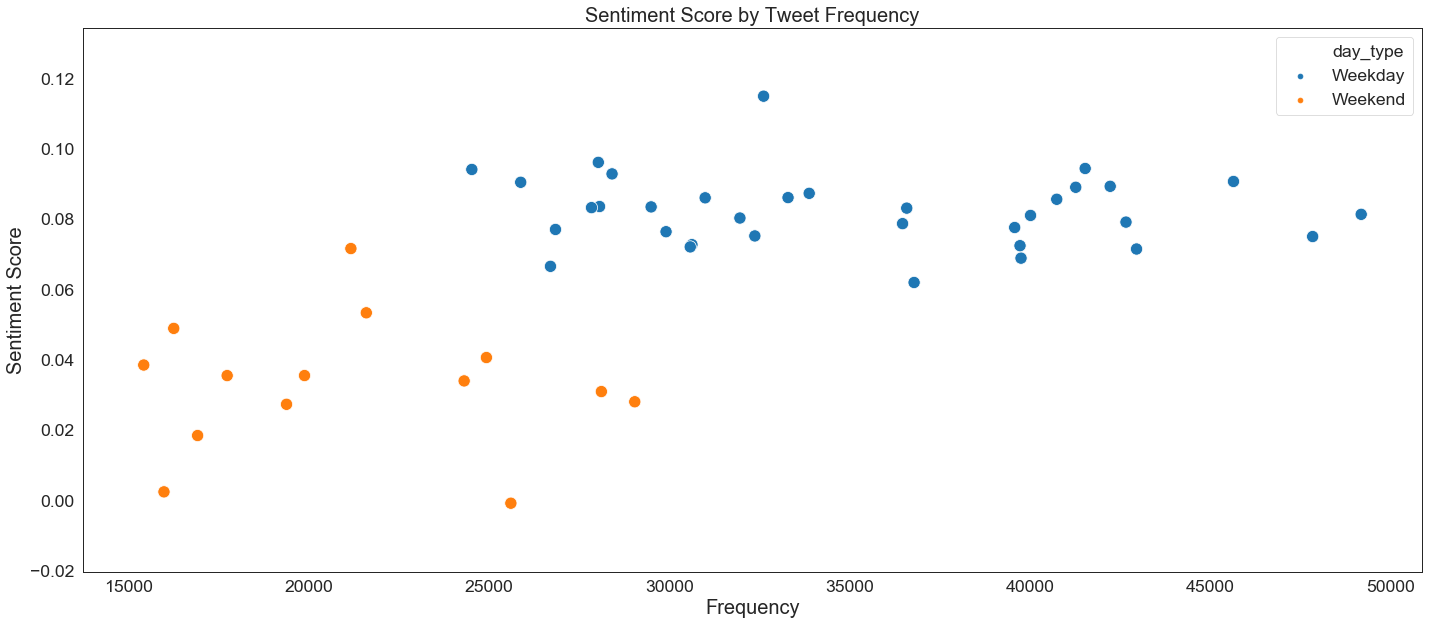

In [681]:
# Scatter plot of sentiment score by Tweet Frequency
ax = sns.scatterplot(x="frequency", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Tweet Frequency",fontsize=20)
plt.xlabel("Frequency", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

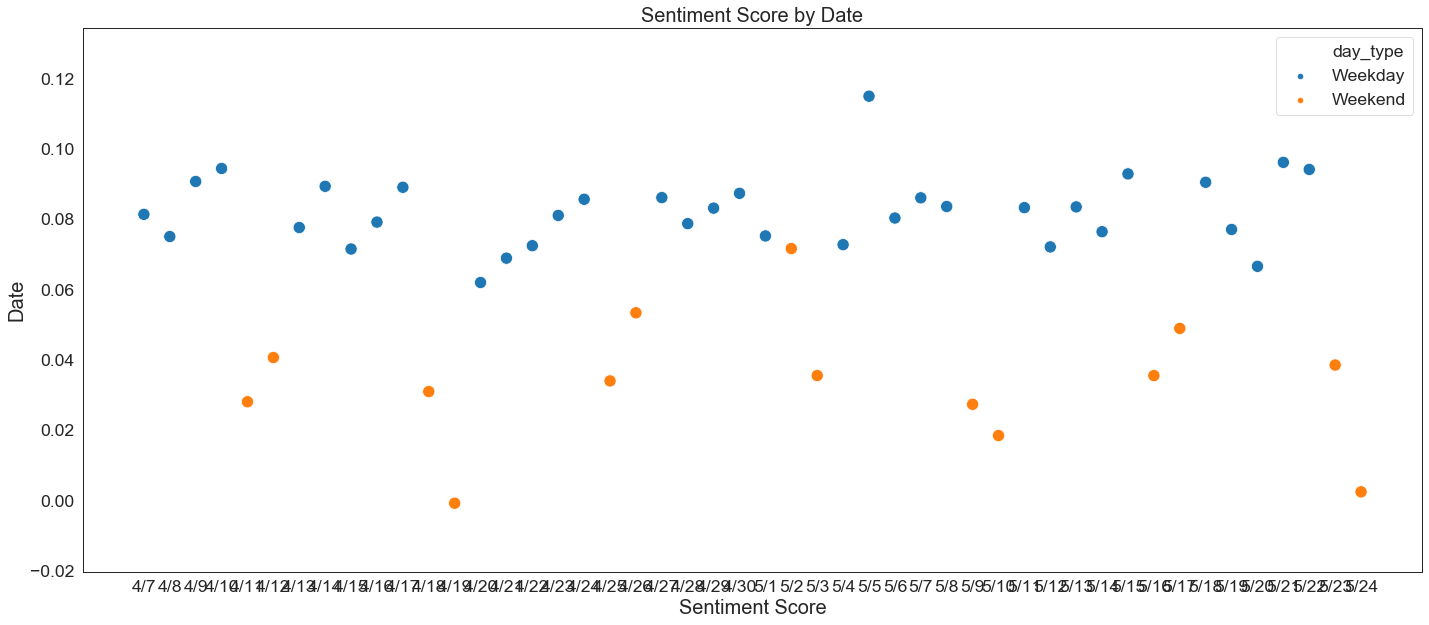

In [638]:
# Daily Sentiment Score by Date - Colored by day type
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 ).set_title("Sentiment Score by Date",fontsize=20)
plt.xlabel("Sentiment Score", fontsize=20)
plt.ylabel("Date", fontsize=20)
plt.show()

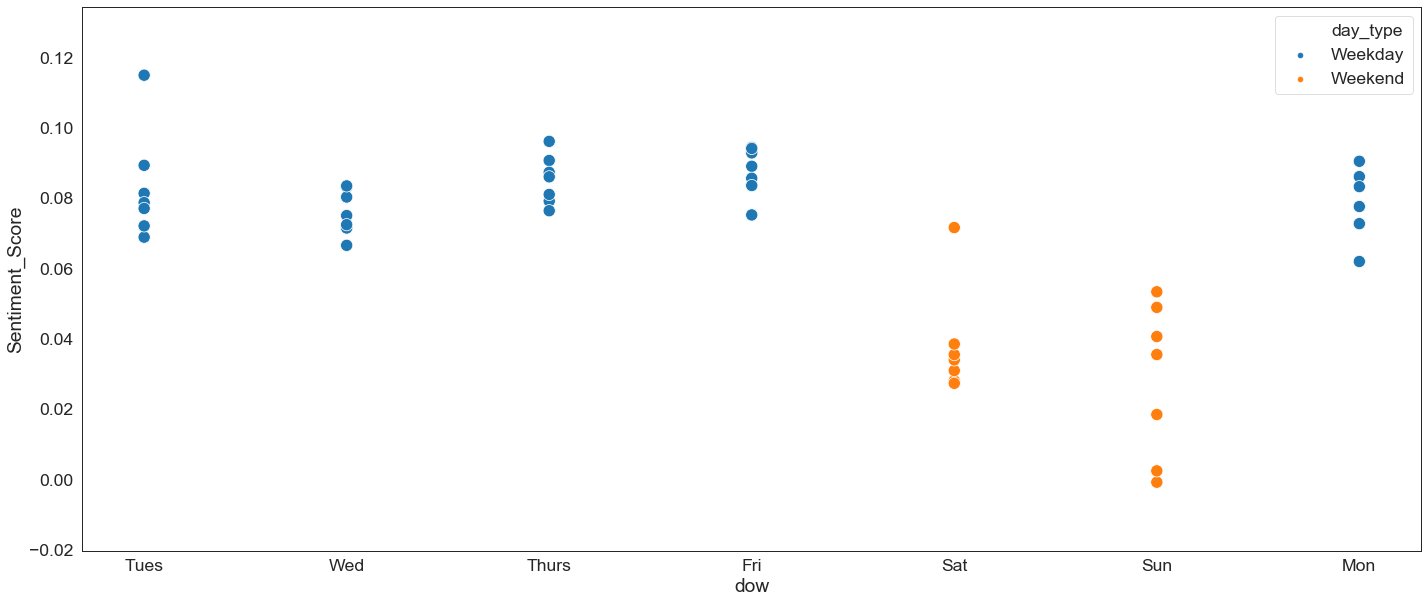

In [639]:
ax = sns.scatterplot(x="dow", y="Sentiment_Score", hue="day_type",
                     data=daily_sentiment_VA, s=150 )

In [688]:
Weekday= daily_sentiment_VA[daily_sentiment_VA['day_type']=='Weekday']
Weekend= daily_sentiment_VA[daily_sentiment_VA['day_type']=='Weekend']

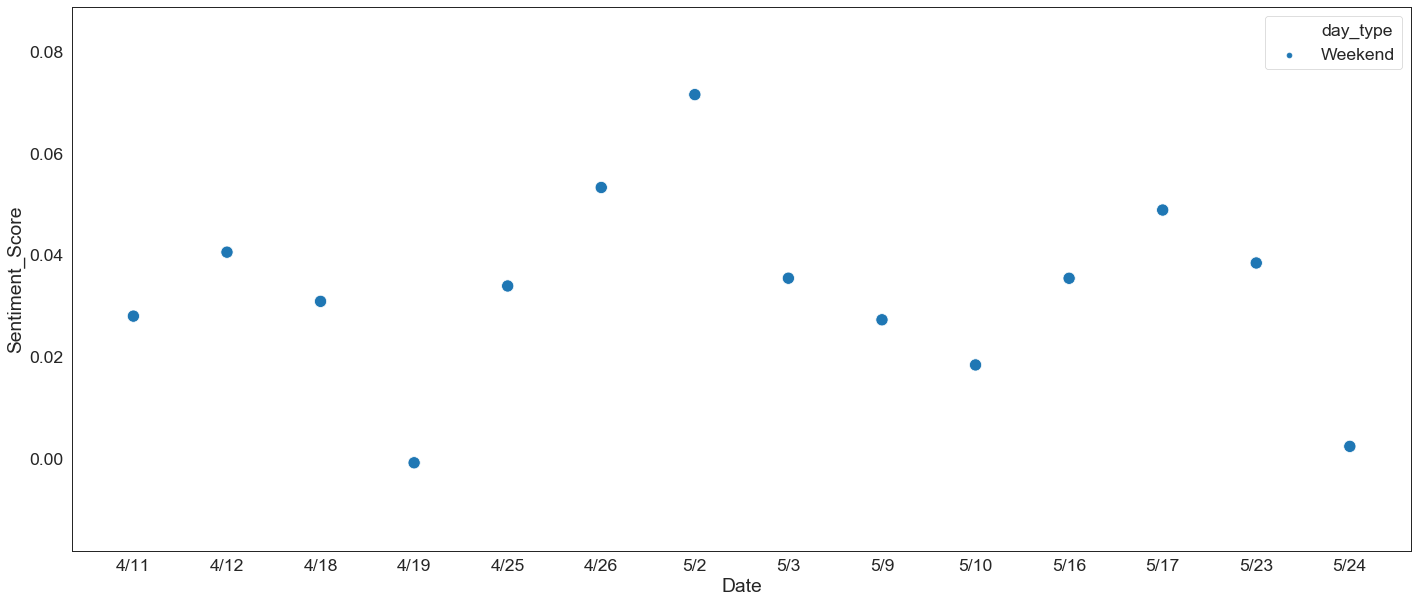

In [691]:
# Avg Weekly Sentiment Score by Percent Change
ax = sns.scatterplot(x="Date", y="Sentiment_Score", hue="day_type",
                     data=Weekend, s=150 )

In [640]:
# Split data by weeks for analysis
Week1= daily_sentiment_VA[daily_sentiment_VA['week']==1]
Week2= daily_sentiment_VA[daily_sentiment_VA['week']==2]
Week3= daily_sentiment_VA[daily_sentiment_VA['week']==3]
Week4= daily_sentiment_VA[daily_sentiment_VA['week']==4]

# Weekly mean sentiment score
daily_sentiment_VA.groupby('week')['Sentiment_Score'].mean()

week
1    0.068302
2    0.062336
3    0.065271
4    0.073884
5    0.068997
6    0.070298
7    0.066406
Name: Sentiment_Score, dtype: float64

In [641]:
# import matplotlib.pyplot as plt

# w1 = Week1['Sentiment_Score'].tolist()
# w2 = Week2['Sentiment_Score'].tolist()
# w3 = Week3['Sentiment_Score'].tolist()
# w4 = Week4['Sentiment_Score'].tolist()

# day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# # "bo" is for "blue dot"
# #plt.plot(day_of_week, w1, 'b', label='Week 1')
# plt.plot(day_of_week, w2, 'g', label='Week 1')
# plt.plot(day_of_week, w3, 'm', label='Week 1')
# plt.plot(day_of_week, w4, 'r', label='Week 1')
# # plt.plot('dow', 'Sentiment_Score', 'r', label='Week 2', data=Week2)
# # plt.plot('dow', 'Sentiment_Score', 'g', label='Week 3', data=Week3)
# # plt.plot('dow', 'Sentiment_Score', 'm', label='Week 4', data=Week4)

# plt.title('Sentiment Scores by week', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()

# plt.show()

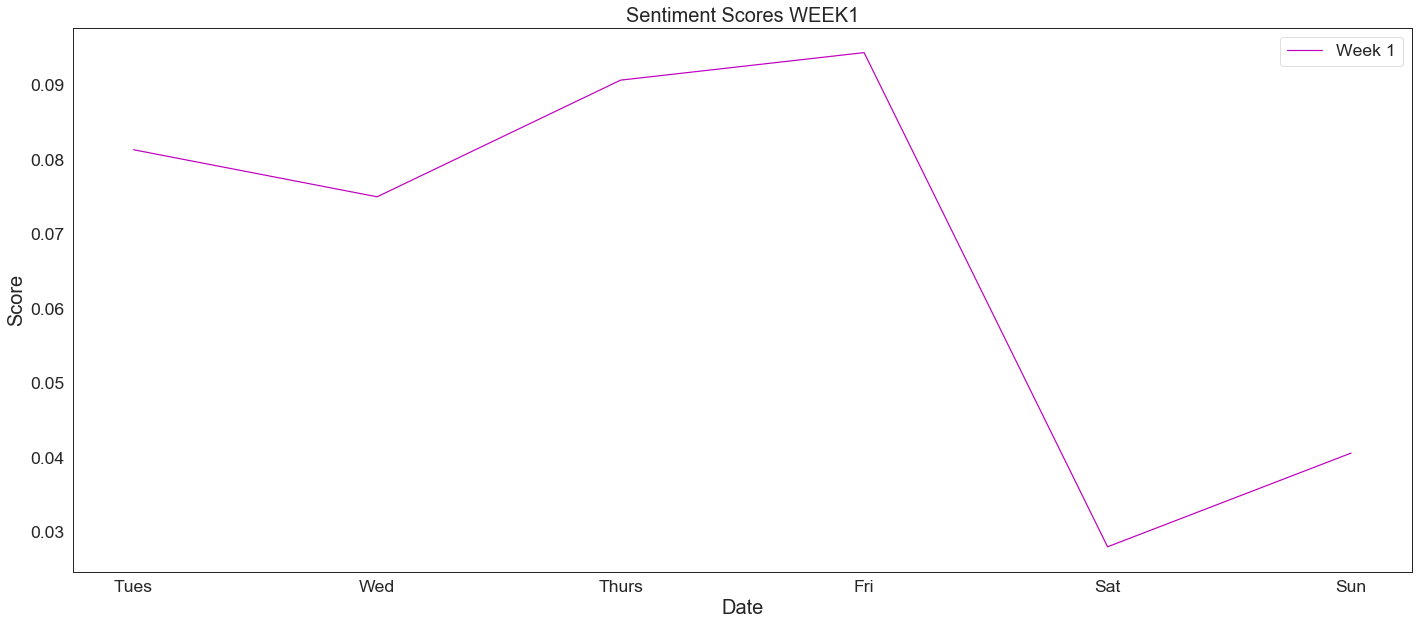

In [642]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 1', data=Week1)
plt.title('Sentiment Scores WEEK1', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

In [643]:
# plt.plot('dow', 'Sentiment_Score', 'm', label='Week 2', data=Week2)
# plt.title('Sentiment Scores WEEK 2', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()
# plt.show()

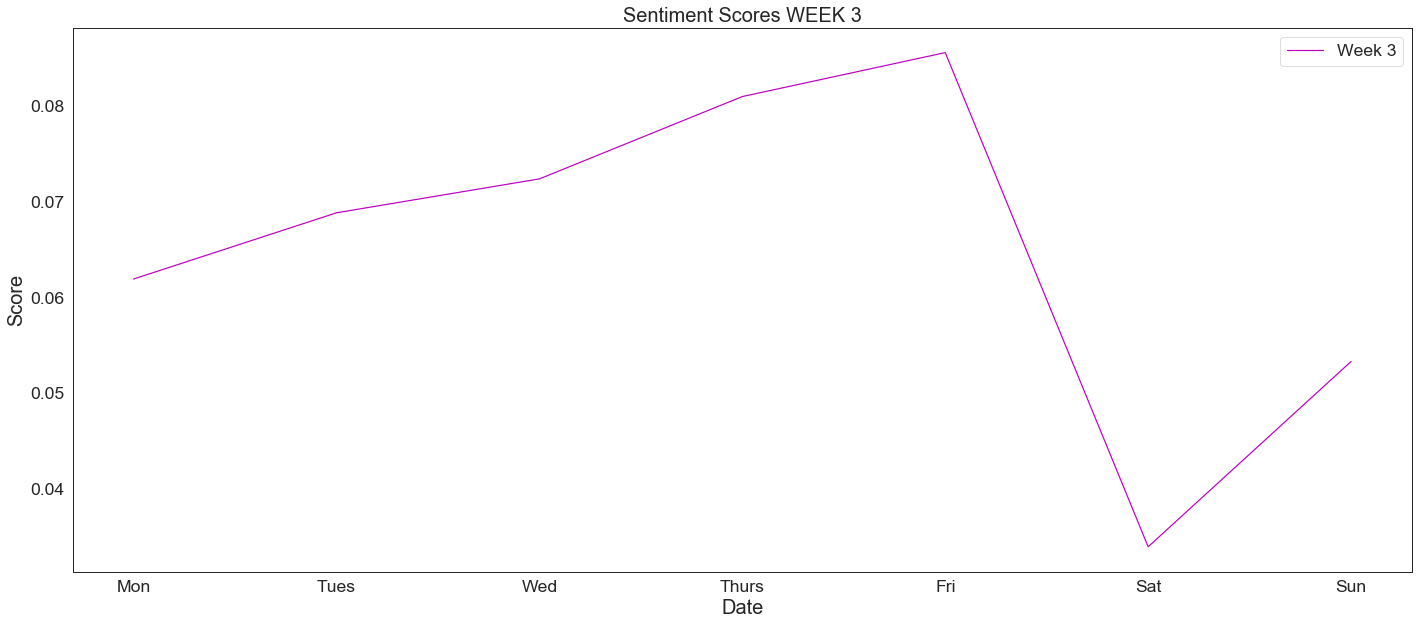

In [644]:
plt.plot('dow', 'Sentiment_Score', 'm', label='Week 3', data=Week3)
plt.title('Sentiment Scores WEEK 3', size=20)
plt.xlabel('Date', size = 20)
plt.ylabel('Score', size = 20)
plt.legend()
plt.show()

In [645]:
# plt.plot('dow', 'Sentiment_Score', 'm', label='Week 4', data=Week4)
# plt.title('Sentiment Scores WEEK 4', size=20)
# plt.xlabel('Date', size = 20)
# plt.ylabel('Score', size = 20)
# plt.legend()
# plt.show()

# Statewide DSS correlation with Covid cases

In [646]:
# read in reported covid cases and deaths data
statewide_covid = pd.read_pickle("/Users/rachelmartonik/covid/statewide_covid.pkl")
statewide_covid.head

<bound method NDFrame.head of     date  Reported_Cases  date  Reported_Deaths
0   4-07  3332.0          4-07  69.0           
1   4-08  3643.0          4-08  60.0           
2   4-09  4039.0          4-09  109.0          
3   4-10  4509.0          4-10  121.0          
4   4-11  5076.0          4-11  130.0          
5   4-12  5271.0          4-12  141.0          
6   4-13  5748.0          4-13  149.0          
7   4-14  6173.0          4-14  154.0          
8   4-15  6502.0          4-15  195.0          
9   4-16  6891.0          4-16  208.0          
10  4-17  7492.0          4-17  238.0          
11  4-18  8054.0          4-18  258.0          
12  4-19  8538.0          4-19  277.0          
13  4-20  8989.0          4-20  300.0          
14  4-21  9629.0          4-21  325.0          
15  4-22  10265.0         4-22  349.0          
16  4-23  10999.0         4-23  375.0          
17  4-24  11595.0         4-24  413.0          
18  4-25  12365.0         4-25  436.0          
19  4-26  

In [647]:
#daily_sentiment_VA = pd.read_csv("daily_sentiment_VA.csv")
daily_sentiment_VA

,frequency,Day_of_Collection,Date,Sentiment_Score,dow,week,day_type
0,49194,1,4/7,0.081293,Tues,1,Weekday
1,47847,2,4/8,0.074978,Wed,1,Weekday
2,45651,3,4/9,0.090639,Thurs,1,Weekday
3,41537,4,4/10,0.094334,Fri,1,Weekday
4,29042,5,4/11,0.027994,Sat,1,Weekend
5,24927,6,4/12,0.040572,Sun,1,Weekend
6,39581,7,4/13,0.077544,Mon,2,Weekday
7,42231,8,4/14,0.089263,Tues,2,Weekday
8,42962,9,4/15,0.071433,Wed,2,Weekday
9,42669,10,4/16,0.079084,Thurs,2,Weekday


In [648]:
# Combine together
statewide_covid_sent = pd.concat([daily_sentiment_VA, statewide_covid], axis=1)
statewide_covid_sent

,frequency,Day_of_Collection,Date,Sentiment_Score,dow,week,day_type,date,Reported_Cases,date,Reported_Deaths
0,49194,1,4/7,0.081293,Tues,1,Weekday,4-07,3332.0,4-07,69.0
1,47847,2,4/8,0.074978,Wed,1,Weekday,4-08,3643.0,4-08,60.0
2,45651,3,4/9,0.090639,Thurs,1,Weekday,4-09,4039.0,4-09,109.0
3,41537,4,4/10,0.094334,Fri,1,Weekday,4-10,4509.0,4-10,121.0
4,29042,5,4/11,0.027994,Sat,1,Weekend,4-11,5076.0,4-11,130.0
5,24927,6,4/12,0.040572,Sun,1,Weekend,4-12,5271.0,4-12,141.0
6,39581,7,4/13,0.077544,Mon,2,Weekday,4-13,5748.0,4-13,149.0
7,42231,8,4/14,0.089263,Tues,2,Weekday,4-14,6173.0,4-14,154.0
8,42962,9,4/15,0.071433,Wed,2,Weekday,4-15,6502.0,4-15,195.0
9,42669,10,4/16,0.079084,Thurs,2,Weekday,4-16,6891.0,4-16,208.0


In [652]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent['Reported_Cases'], statewide_covid_sent['Sentiment_Score'])
print(pvalue)
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
corr, pvalue = pearsonr(statewide_covid_sent['Reported_Deaths'], statewide_covid_sent['Sentiment_Score'])
print(pvalue)
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)



0.7233746650208935
Pearsons correlation of reported cases and Sentiment Score: -0.052
0.7428033395597164
Pearsons correlation of reported deaths and Sentiment Score: -0.049


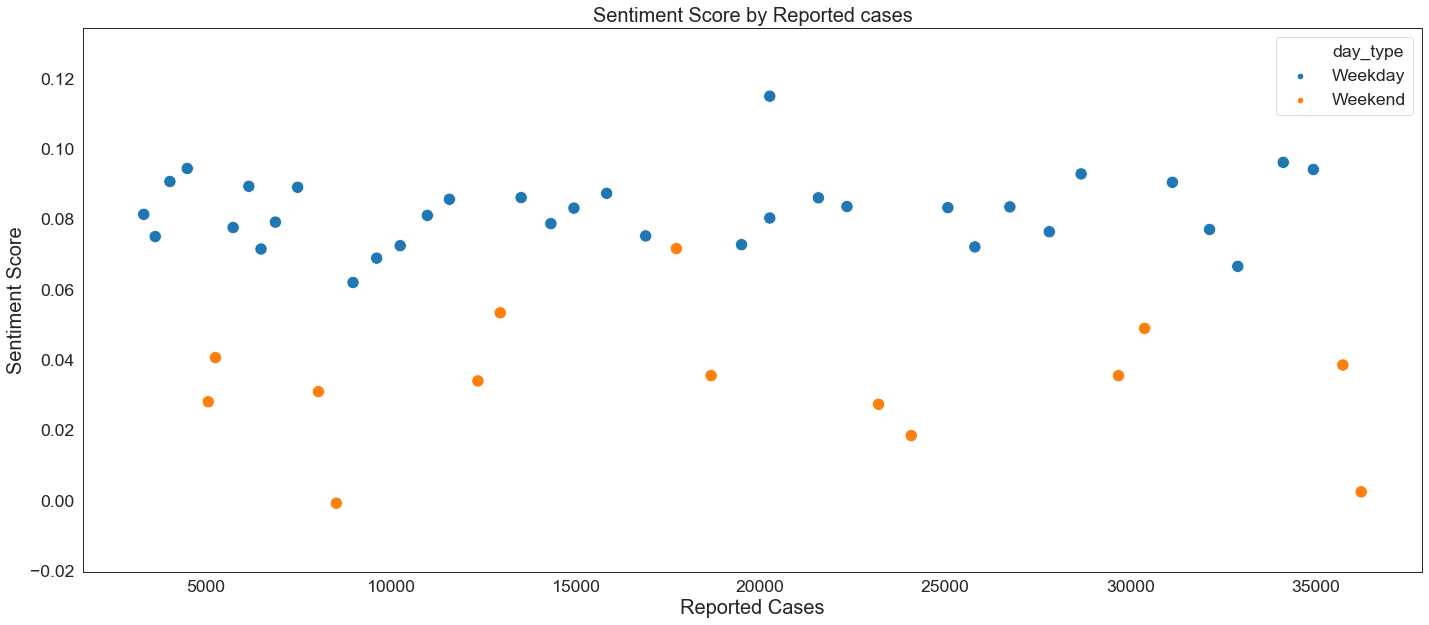

In [650]:
# Scatter plot of sentiment score by reported cases
ax = sns.scatterplot(x="Reported_Cases", y="Sentiment_Score", hue="day_type",
                     data=statewide_covid_sent, s=150 ).set_title("Sentiment Score by Reported cases",fontsize=20)
plt.xlabel("Reported Cases", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

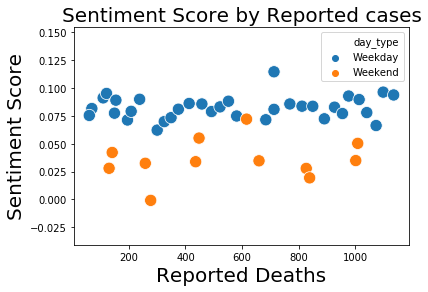

In [339]:
# Scatter plot of sentiment score by reported deaths
ax = sns.scatterplot(x="Reported_Deaths", y="Sentiment_Score", hue="day_type",
                     data=statewide_covid_sent, s=150 ).set_title("Sentiment Score by Reported cases",fontsize=20)
plt.xlabel("Reported Deaths", fontsize=20)
plt.ylabel("Sentiment Score", fontsize=20)
plt.savefig("DSS-Overall by Tweet Frequency", tight_layout=False)
plt.show()

In [653]:
# Create percent change of reported cases and deaths
a = statewide_covid_sent.groupby('week',sort=False).apply(lambda x: (x['Reported_Cases'].values[-1] - x['Reported_Cases'].values[0]) / x['Reported_Cases'].values[-1] * 100)\
    .reset_index(name='pct_change_cases')
a


,week,pct_change_cases
0,1,36.786189
1,2,32.677442
2,3,30.688565
3,4,27.513256
4,5,19.056518
5,6,17.500329
6,7,14.082331


In [654]:
b = statewide_covid_sent.groupby('week',sort=False).apply(lambda x: (x['Reported_Deaths'].values[-1] - x['Reported_Deaths'].values[0]) / x['Reported_Deaths'].values[-1] * 100)\
    .reset_index(name='pct_change_deaths')
b

,week,pct_change_deaths
0,1,51.063830
1,2,46.209386
2,3,33.035714
3,4,30.606061
4,5,18.474374
5,6,15.758176
6,7,13.407344


In [655]:
c = statewide_covid_sent.groupby('week')['Sentiment_Score'].mean().reset_index(name='avg_weekly_sent')
c

,week,avg_weekly_sent
0,1,0.068302
1,2,0.062336
2,3,0.065271
3,4,0.073884
4,5,0.068997
5,6,0.070298
6,7,0.066406


In [656]:
statewide_covid_sent_weekly = pd.concat([a, b, c], axis=1)
statewide_covid_sent_weekly

,week,pct_change_cases,week,pct_change_deaths,week,avg_weekly_sent
0,1,36.786189,1,51.063830,1,0.068302
1,2,32.677442,2,46.209386,2,0.062336
2,3,30.688565,3,33.035714,3,0.065271
3,4,27.513256,4,30.606061,4,0.073884
4,5,19.056518,5,18.474374,5,0.068997
5,6,17.500329,6,15.758176,6,0.070298
6,7,14.082331,7,13.407344,7,0.066406


In [686]:
# drop to first six weeks
statewide_covid_sent_weekly_six = statewide_covid_sent_weekly.copy()
statewide_covid_sent_weekly_six.drop(statewide_covid_sent_weekly_six.tail(1).index,inplace=True)
statewide_covid_sent_weekly_six

,week,pct_change_cases,week,pct_change_deaths,week,avg_weekly_sent
0,1,36.786189,1,51.063830,1,0.068302
1,2,32.677442,2,46.209386,2,0.062336
2,3,30.688565,3,33.035714,3,0.065271
3,4,27.513256,4,30.606061,4,0.073884
4,5,19.056518,5,18.474374,5,0.068997
5,6,17.500329,6,15.758176,6,0.070298


In [687]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent_weekly_six['pct_change_cases'], statewide_covid_sent_weekly_six['avg_weekly_sent'])
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")
corr, pvalue = pearsonr(statewide_covid_sent_weekly_six['pct_change_deaths'], statewide_covid_sent_weekly_six['avg_weekly_sent'])
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")

Pearsons correlation of reported cases and Sentiment Score: -0.432
p-value: 0.3925431206502197
Pearsons correlation of reported deaths and Sentiment Score: -0.481
p-value: 0.3345526102331032


In [659]:
from scipy.stats import pearsonr
corr, pvalue = pearsonr(statewide_covid_sent_weekly['pct_change_cases'], statewide_covid_sent_weekly['avg_weekly_sent'])
print('Pearsons correlation of reported cases and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")
corr, pvalue = pearsonr(statewide_covid_sent_weekly['pct_change_deaths'], statewide_covid_sent_weekly['avg_weekly_sent'])
print('Pearsons correlation of reported deaths and Sentiment Score: %.3f' % corr)
print(f"p-value: {pvalue}")

Pearsons correlation of reported cases and Sentiment Score: -0.240
p-value: 0.6040497440505164
Pearsons correlation of reported deaths and Sentiment Score: -0.326
p-value: 0.4761127772552766


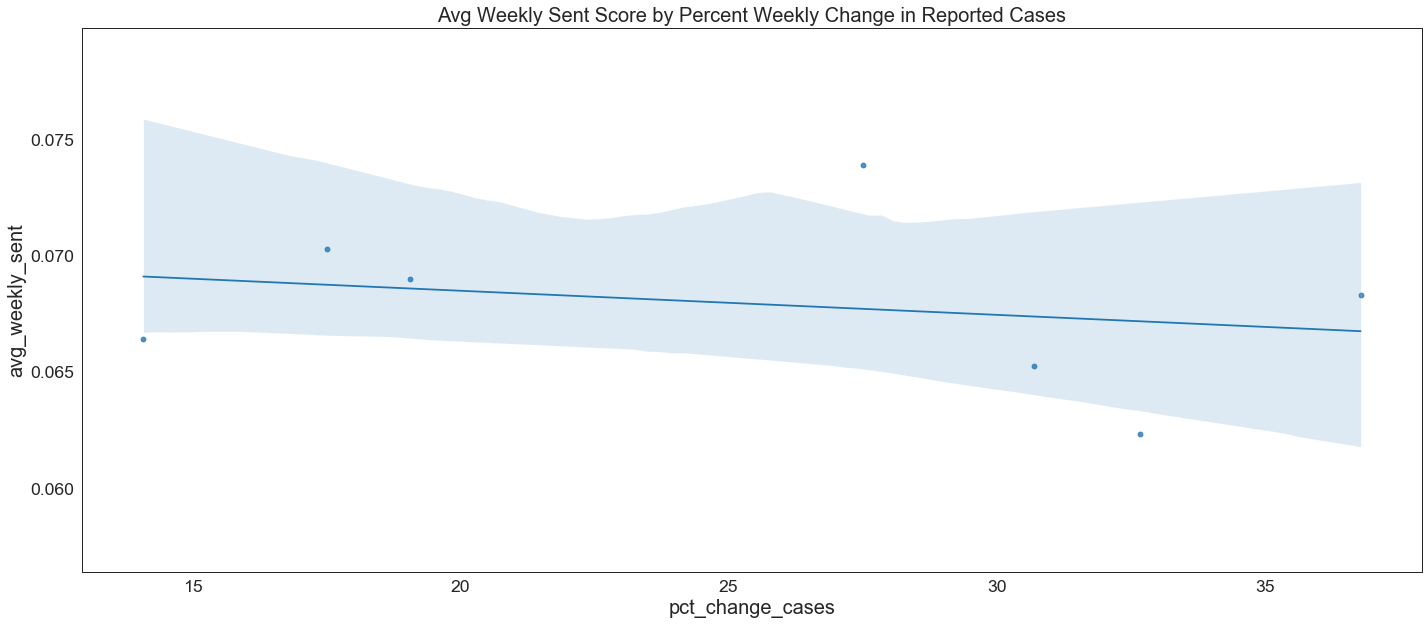

In [660]:
# Avg Weekly Sentiment Score by Percent Change
ax = sns.regplot(x="pct_change_cases", y="avg_weekly_sent",
                     data=statewide_covid_sent_weekly).set_title("Avg Weekly Sent Score by Percent Weekly Change in Reported Cases",fontsize=20)
plt.xlabel("pct_change_cases", fontsize=20)
plt.ylabel("avg_weekly_sent", fontsize=20)
plt.show()

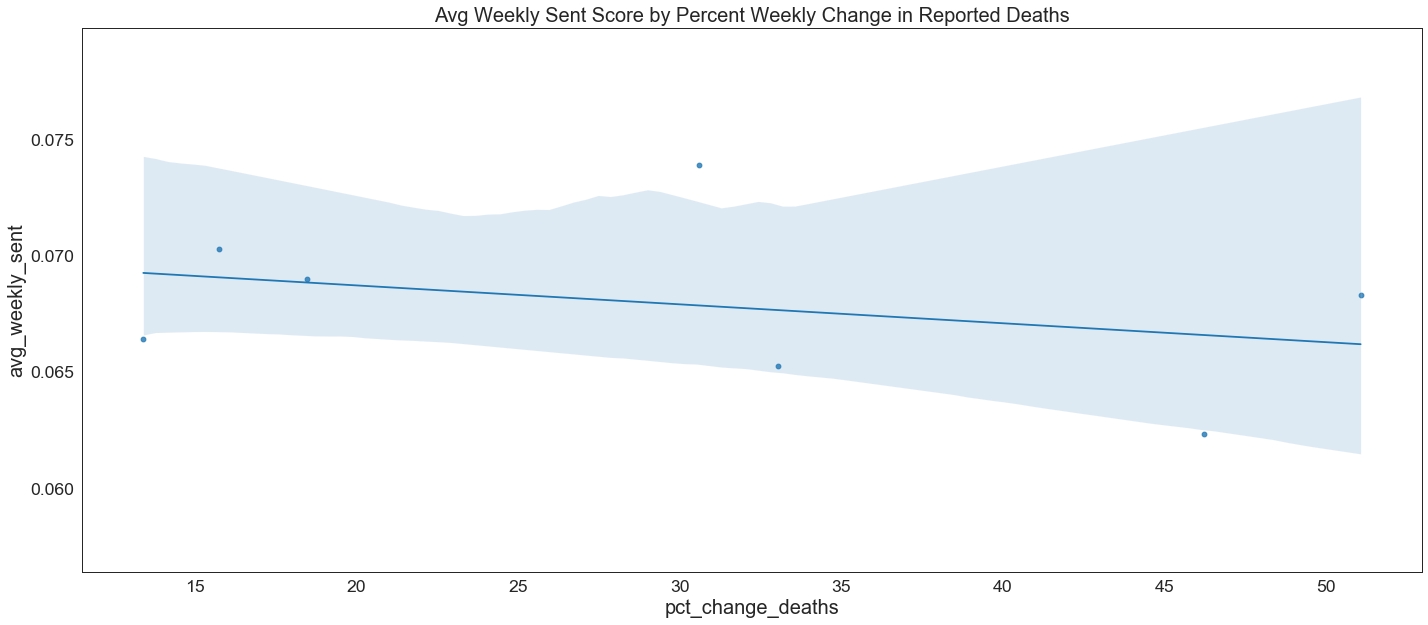

In [661]:
# Avg Weekly Sentiment Score by Percent Change
ax = sns.regplot(x="pct_change_deaths", y="avg_weekly_sent",
                     data=statewide_covid_sent_weekly).set_title("Avg Weekly Sent Score by Percent Weekly Change in Reported Deaths",fontsize=20)
plt.xlabel("pct_change_deaths", fontsize=20)
plt.ylabel("avg_weekly_sent", fontsize=20)
plt.show()

# Daily Sentiment Score By County

Use the code below to run through each cleaned daily data set (i.e data_0407_clean). The code takes the Tweet and provides a sentiment score. Then I appened county to each data set (not all counties have Tweets each day), and ran the mean sentiment score for that day by county. At the end, I compiled the daily scores into a data frame with all counties.

Code has been commented out because it only needs to be run once for each day of data.

In [709]:
# # Run through each daily data set separetly to get county level sentiment score
# data = data_0524_clean
# day = '05-24'

# text_body=[] #Loop through tweet to prepare for sentiment analysis
# sentiment_score = [] # Append sentiment analysis results to a list
# for i in range(0,len(data)):
#     temp_text=data['text'].iloc[i]
#     text_body.append(temp_text)
    
# sentences = text_body # Sentiment analysis
   
# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
#     sentiment_score.append(vs)

# # Create data frame of county names
# locations = pd.DataFrame(data['county_name'])
# locations.reset_index(inplace=True)
# #locations

In [710]:
# # append sentiment with county name
# a = pd.DataFrame(sentiment_score)
# b = pd.concat([a, locations], axis=1)
# print (len(a))
# print (len(b))
# print (len(data))

1414
1414
1414


In [711]:
# len(b.county_name.value_counts())

77

In [712]:
# c = pd.DataFrame(b.groupby('county_name')['compound'].mean())
# c.reset_index(inplace=True)
# c.columns=['county_name', day]
# sent_0524 = c
# sent_0524.to_pickle("sent_0524.pkl") # save the file


# COVID Tracking Data

In a separate notebook, I pull daily Covid data for confirmed number of cases and deaths for Virginia. I added population data from ACS, normalizing the number of cases and deaths by every 1000 county/city resident.

In [713]:
cases = pd.read_csv("cases_per_1000.csv") 
cases.drop(columns=['Unnamed: 0'], inplace=True)
deaths = pd.read_csv("deaths_per_1000.csv") 
deaths.drop(columns=['Unnamed: 0'], inplace=True)
#cases.rename(columns={'county_lower':'county_name'}, inplace=True)
#deaths.rename(columns={'county_lower':'county_name'}, inplace=True)

In [714]:
name_change_dict = {"county_lower": "county_name",
                    "2020-04-07_per": "04-07",
                    "2020-04-08_per": "04-08",
                    "2020-04-09_per": "04-09",
                    "2020-04-10_per": "04-10",
                    "2020-04-11_per": "04-11",
                    "2020-04-12_per": "04-12",
                    "2020-04-13_per": "04-13",
                    "2020-04-14_per": "04-14",
                    "2020-04-15_per": "04-15",
                    "2020-04-16_per": "04-16",
                    "2020-04-17_per": "04-17",
                    "2020-04-18_per": "04-18",
                    "2020-04-19_per": "04-19",
                    "2020-04-20_per": "04-20",
                    "2020-04-21_per": "04-21",
                    "2020-04-22_per": "04-22",
                    "2020-04-23_per": "04-23",
                    "2020-04-24_per": "04-24",
                    "2020-04-25_per": "04-25",
                    "2020-04-26_per": "04-26",
                    "2020-04-27_per": "04-27",
                    "2020-04-28_per": "04-28",
                    "2020-04-29_per": "04-29",
                    "2020-04-30_per": "04-30",
                    "2020-05-01_per": "05-01",
                    "2020-05-02_per": "05-02",
                    "2020-05-03_per": "05-03",
                    "2020-05-04_per": "05-04",
                    "2020-05-05_per": "05-05",
                    "2020-05-06_per": "05-06",
                    "2020-05-07_per": "05-07",
                    "2020-05-08_per": "05-08", 
                    "2020-05-09_per": "05-09", 
                    "2020-05-10_per": "05-10", 
                    "2020-05-11_per": "05-11", 
                    "2020-05-12_per": "05-12", 
                    "2020-05-13_per": "05-13", 
                    "2020-05-14_per": "05-14", 
                    "2020-05-15_per": "05-15", 
                    "2020-05-16_per": "05-16", 
                    "2020-05-17_per": "05-17", 
                    "2020-05-18_per": "05-18", 
                    "2020-05-19_per": "05-19", 
                    "2020-05-20_per": "05-20", 
                    "2020-05-21_per": "05-21", 
                    "2020-05-22_per": "05-22", 
                    "2020-05-23_per": "05-23", 
                    "2020-05-24_per": "05-24", 
                   }

cases.rename(columns=name_change_dict, inplace=True)
deaths.rename(columns=name_change_dict, inplace=True)

In [715]:
deaths.head()

,county_name,percent_VA_pop,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,...,05-15,05-16,05-17,05-18,05-19,05-20,05-21,05-22,05-23,05-24
0,accomack county,0.003891,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.274876,0.274876,0.274876,0.274876,0.274876,0.335960,0.335960,0.335960,0.335960,0.335960
1,albemarle county,0.012641,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.037610,0.037610,0.037610,0.037610,0.037610,0.037610,0.037610,0.037610,0.047012,0.075220
2,alexandria city,0.018601,0.00639,0.00639,0.00639,0.00639,0.00639,0.00639,0.00639,0.00639,...,0.204466,0.217245,0.217245,0.217245,0.217245,0.217245,0.236414,0.236414,0.242804,0.242804
3,alleghany county,0.001817,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130839,0.130839,0.130839
4,amelia county,0.001528,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.077797,0.077797,0.077797,0.077797,0.077797,0.077797,0.077797,0.077797,0.077797,0.077797


In [716]:
# Create separate dataframe of percent of US VA population
percent_VA_population = cases[['county_name', 'percent_VA_pop']]
percent_VA_population.head()
len(percent_VA_population)

133

In [717]:
# Drop percent of population from cases and deaths
cases = cases.drop(columns='percent_VA_pop')
deaths = deaths.drop(columns='percent_VA_pop')

In [718]:
# Create wide COVID cases and deaths data

cases_wide = pd.melt(cases, id_vars=['county_name'])
deaths_wide = pd.melt(deaths, id_vars=['county_name'])
cases_wide.columns=['county_name', 'date', 'cases_per_1000']
deaths_wide.columns=['county_name', 'date', 'deahts_per_1000']

In [719]:
# Save wide COVID case to file - used in Tableau
cases_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/cases_wide.csv")
deaths_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/deaths_wide.csv")

In [720]:
cases_wide.head()

,county_name,date,cases_per_1000
0,accomack county,04-07,0.335960
1,albemarle county,04-07,0.357294
2,alexandria city,04-07,0.805086
3,alleghany county,04-07,0.130839
4,amelia county,04-07,0.544578


In [721]:
cases_wide['cases_per_1000'].describe()

count    6260.000000
mean     1.681073   
std      2.942274   
min      0.000000   
25%      0.380097   
50%      0.772798   
75%      1.648946   
max      31.088083  
Name: cases_per_1000, dtype: float64

## County/City Checks

VA has 133 total counties/cities included in ACS data. As of 5/2 (Data as of 4/30), the following discrepancies exist:

Counties in Twitter data but not COVID data:
 - Martinsville city
 - Dickenson county
 - Bland county
 - Bath county

Counites in Covid data but not in Twitter data:
 - Buena Vista city
 - Chesapeake city
 - Covington city
 - Greensville county

In [722]:
# How many unique county/cities do we have in entire merged data?
county_list = merged_cleaned_data['county_name'].value_counts()
Twitter_counties = pd.DataFrame(county_list)
Twitter_counties.reset_index(inplace=True)
Twitter_counties= Twitter_counties['index']
Twitter_counties = pd.DataFrame(Twitter_counties)
Twitter_counties.columns=['county_name']
Twitter_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/Twitter_counties.csv")

In [723]:
#Twitter_counties

In [724]:
covid_counties = pd.DataFrame(cases.county_name)
covid_counties.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/covid_counties.csv")

In [725]:
county_check = pd.merge(covid_counties, Twitter_counties, on='county_name')
#county_check

## Daily Sentiment Score Data Frame

For now, we will include counites/cities included in both the Twitter data and the COVID data as we are trying to compare the two. Will reassess later on in course.

In [726]:
# Read in data
sent_0407 = pd.read_pickle('sent_0407.pkl')
sent_0408 = pd.read_pickle('sent_0408.pkl')
sent_0409 = pd.read_pickle('sent_0409.pkl')
sent_0410 = pd.read_pickle('sent_0410.pkl')
sent_0411 = pd.read_pickle('sent_0411.pkl')
sent_0412 = pd.read_pickle('sent_0412.pkl')
sent_0413 = pd.read_pickle('sent_0413.pkl')
sent_0414 = pd.read_pickle('sent_0414.pkl')
sent_0415 = pd.read_pickle('sent_0415.pkl')
sent_0416 = pd.read_pickle('sent_0416.pkl')
sent_0417 = pd.read_pickle('sent_0417.pkl')
sent_0418 = pd.read_pickle('sent_0418.pkl')
sent_0419 = pd.read_pickle('sent_0419.pkl')
sent_0420 = pd.read_pickle('sent_0420.pkl')
sent_0421 = pd.read_pickle('sent_0421.pkl')
sent_0422 = pd.read_pickle('sent_0422.pkl')
sent_0423 = pd.read_pickle('sent_0423.pkl')
sent_0424 = pd.read_pickle('sent_0424.pkl')
sent_0425 = pd.read_pickle('sent_0425.pkl')
sent_0426 = pd.read_pickle('sent_0426.pkl')
sent_0427 = pd.read_pickle('sent_0427.pkl')
sent_0428 = pd.read_pickle('sent_0428.pkl')
sent_0429 = pd.read_pickle('sent_0429.pkl')
sent_0430 = pd.read_pickle('sent_0430.pkl')
sent_0501 = pd.read_pickle('sent_0501.pkl')
sent_0502 = pd.read_pickle('sent_0502.pkl')
sent_0503 = pd.read_pickle('sent_0503.pkl')
sent_0504 = pd.read_pickle('sent_0504.pkl')
sent_0505 = pd.read_pickle('sent_0505.pkl')
sent_0506 = pd.read_pickle('sent_0506.pkl')
sent_0507 = pd.read_pickle('sent_0507.pkl')
sent_0508 = pd.read_pickle('sent_0508.pkl')
sent_0509 = pd.read_pickle('sent_0509.pkl')
sent_0510 = pd.read_pickle('sent_0510.pkl')
sent_0511 = pd.read_pickle('sent_0511.pkl')
sent_0512 = pd.read_pickle('sent_0512.pkl')
sent_0513 = pd.read_pickle('sent_0513.pkl')
sent_0514 = pd.read_pickle('sent_0514.pkl')
sent_0515 = pd.read_pickle('sent_0515.pkl')
sent_0516 = pd.read_pickle('sent_0516.pkl')
sent_0517 = pd.read_pickle('sent_0517.pkl')
sent_0518 = pd.read_pickle('sent_0518.pkl')
sent_0519 = pd.read_pickle('sent_0519.pkl')
sent_0520 = pd.read_pickle('sent_0520.pkl')
sent_0521 = pd.read_pickle('sent_0521.pkl')
sent_0522 = pd.read_pickle('sent_0522.pkl')
sent_0523 = pd.read_pickle('sent_0523.pkl')
sent_0524 = pd.read_pickle('sent_0524.pkl')



In [727]:
# Create blank DSS Daily Sentiment Score data frame
DSS = county_check
DSS.columns=['county_name']
DSS.head()

,county_name
0,accomack county
1,albemarle county
2,alexandria city
3,alleghany county
4,amelia county


In [728]:
date_list = [sent_0407, sent_0408, sent_0409, sent_0410, sent_0411, sent_0412, sent_0413, sent_0414, sent_0415, 
             sent_0416, sent_0417, sent_0418, sent_0419, sent_0420, sent_0421, sent_0422, sent_0423, sent_0424, 
             sent_0425, sent_0426, sent_0427, sent_0428, sent_0429, sent_0430, sent_0501, sent_0502, sent_0503,
             sent_0504, sent_0505, sent_0506, sent_0507, sent_0508, sent_0509, sent_0510, sent_0511, sent_0512,
            sent_0513, sent_0514, sent_0515, sent_0516, sent_0517, sent_0518, sent_0519, sent_0520, sent_0521,
            sent_0522, sent_0523, sent_0524]


In [729]:
sent_0509

,county_name,05-09
0,accomack county,-0.371500
1,albemarle county,-0.193450
2,alexandria city,-0.053042
3,amherst county,0.345050
4,arlington county,0.149952
5,augusta county,0.034489
6,bedford county,0.098963
7,bristol city,0.141933
8,campbell county,-0.795750
9,caroline county,0.000000


In [237]:
sent_0510

,county_name,05-10
0,accomack county,0.377400
1,albemarle county,-0.424250
2,alexandria city,0.086298
3,amherst county,-0.613650
4,arlington county,-0.017906
...,...,...
64,westmoreland county,0.000000
65,williamsburg city,0.004627
66,winchester city,0.134233
67,wise county,-0.719100


In [730]:
for i in date_list:
    DSS = pd.merge(DSS, i, on='county_name', how="left")

In [731]:
DSS.columns.values.tolist()

['county_name',
 '04-07',
 '04-08',
 '04-09',
 '04-10',
 '04-11',
 '04-12',
 '04-13',
 '04-14',
 '04-15',
 '04-16',
 '04-17',
 '04-18',
 '04-19',
 '04-20',
 '04-21',
 '04-22',
 '04-23',
 '04-24',
 '04-25',
 '04-26',
 '04-27',
 '04-28',
 '04-29',
 '04-30',
 '05-01',
 '05-02',
 '05-03',
 '05-04',
 '05-05',
 '05-06',
 '05-07',
 '05-08',
 '05-09',
 '05-10',
 '05-11',
 '05-12',
 '05-13',
 '05-14',
 '05-15',
 '05-16',
 '05-17',
 '05-18',
 '05-19',
 '05-20',
 '05-21',
 '05-22',
 '05-23',
 '05-24']

## Adding Daily Tweet Frequency by County

In [794]:
county_list = pd.DataFrame(merged_cleaned_data['county_name'].value_counts())
county_list.head()

,county_name
fairfax county,18548
richmond city,15692
arlington county,12109
alexandria city,11116
charlottesville city,6854


In [759]:
# LIST OF DAILY DATA SETS TO PROCESS
dates_cleaned = [data_0407_clean, data_0408_clean, data_0409_clean, data_0410_clean, data_0411_clean, data_0412_clean,
                data_0413_clean, data_0414_clean, data_0415_clean, data_0416_clean, data_0417_clean, data_0418_clean, 
                 data_0419_clean, data_0420_clean, data_0421_clean, data_0422_clean, data_0423_clean, data_0424_clean, 
                 data_0425_clean, data_0426_clean, data_0427_clean, data_0428_clean, data_0429_clean, data_0430_clean,
                data_0501_clean, data_0502_clean, data_0503_clean, data_0504_clean, data_0505_clean, data_0506_clean, 
                 data_0507_clean, data_0508_clean, data_0509_clean, data_0510_clean, data_0511_clean, data_0512_clean,
                data_0513_clean, data_0514_clean, data_0515_clean, data_0516_clean, data_0517_clean, data_0518_clean,
                data_0519_clean, data_0520_clean, data_0521_clean, data_0522_clean, data_0523_clean, data_0524_clean]

In [795]:
b = county_list
b.reset_index(inplace=True)
b

,index,county_name
0,fairfax county,18548
1,richmond city,15692
2,arlington county,12109
3,alexandria city,11116
4,charlottesville city,6854
5,virginia beach city,5987
6,essex county,5156
7,norfolk city,5048
8,loudoun county,4156
9,prince william county,2261


In [796]:
b.drop(columns="county_name", inplace=True)
#b.columns=["county_name"]
b

,index
0,fairfax county
1,richmond city
2,arlington county
3,alexandria city
4,charlottesville city
5,virginia beach city
6,essex county
7,norfolk city
8,loudoun county
9,prince william county


In [777]:
# b = county_list
# b.reset_index(inplace=True)
# b

In [ ]:
# b.columns=["throw", "county_name"]
# b
# b.reset_index(inplace=True)
# b

In [947]:
# data = data_0407_clean
# name = '04-07'

# # A is file with just current file run
# a = data.groupby(['county_name']).count() #get tweet frequency for data file for each county
# a = a[['user_id']] # Rename for now

In [948]:
# a.rename(columns={'user_id': name}, inplace=True)
# a.reset_index(inplace=True)


In [949]:
c = pd.merge(c, a, on='county_name', how="left")
c.head()

,throw,county_name,05-24,05-23,05-22,05-21,05-20,05-19,05-18,05-17,...,04-16,04-15,04-14,04-13,04-12,04-11,04-10,04-09,04-08,04-07
0,0,fairfax county,183.0,211.0,319.0,346.0,352.0,372.0,369.0,171.0,...,504.0,572.0,541.0,490.0,256.0,288.0,540.0,561.0,608.0,635.0
1,1,richmond city,170.0,108.0,272.0,268.0,263.0,311.0,274.0,163.0,...,462.0,463.0,434.0,470.0,253.0,282.0,417.0,508.0,536.0,535.0
2,2,arlington county,138.0,86.0,237.0,254.0,261.0,224.0,258.0,91.0,...,348.0,358.0,361.0,363.0,148.0,181.0,396.0,384.0,385.0,414.0
3,3,alexandria city,117.0,106.0,185.0,249.0,211.0,196.0,214.0,115.0,...,329.0,325.0,340.0,339.0,143.0,158.0,336.0,343.0,368.0,398.0
4,4,charlottesville city,78.0,47.0,116.0,138.0,152.0,99.0,130.0,66.0,...,186.0,217.0,205.0,187.0,109.0,115.0,172.0,206.0,208.0,206.0


In [950]:
c.drop(columns=['throw'], inplace=True)

In [953]:
DTF = c
DTF.to_csv("DTF.csv")
DTF.to_pickle("DTF.pickle")

In [954]:
DTF.head()

,county_name,05-24,05-23,05-22,05-21,05-20,05-19,05-18,05-17,05-16,...,04-16,04-15,04-14,04-13,04-12,04-11,04-10,04-09,04-08,04-07
0,fairfax county,183.0,211.0,319.0,346.0,352.0,372.0,369.0,171.0,211.0,...,504.0,572.0,541.0,490.0,256.0,288.0,540.0,561.0,608.0,635.0
1,richmond city,170.0,108.0,272.0,268.0,263.0,311.0,274.0,163.0,154.0,...,462.0,463.0,434.0,470.0,253.0,282.0,417.0,508.0,536.0,535.0
2,arlington county,138.0,86.0,237.0,254.0,261.0,224.0,258.0,91.0,110.0,...,348.0,358.0,361.0,363.0,148.0,181.0,396.0,384.0,385.0,414.0
3,alexandria city,117.0,106.0,185.0,249.0,211.0,196.0,214.0,115.0,101.0,...,329.0,325.0,340.0,339.0,143.0,158.0,336.0,343.0,368.0,398.0
4,charlottesville city,78.0,47.0,116.0,138.0,152.0,99.0,130.0,66.0,73.0,...,186.0,217.0,205.0,187.0,109.0,115.0,172.0,206.0,208.0,206.0


In [955]:
# Create long data
DTF_long = pd.melt(DTF, id_vars=['county_name'])
DTF_long.columns=['county_name', 'date', 'frequency']
DTF_long.head()

,county_name,date,frequency
0,fairfax county,05-24,183.0
1,richmond city,05-24,170.0
2,arlington county,05-24,138.0
3,alexandria city,05-24,117.0
4,charlottesville city,05-24,78.0


In [956]:
# Replace missing values with 0s
DTF_long.fillna(0, inplace=True)
DTF_long

,county_name,date,frequency
0,fairfax county,05-24,183.0
1,richmond city,05-24,170.0
2,arlington county,05-24,138.0
3,alexandria city,05-24,117.0
4,charlottesville city,05-24,78.0
...,...,...,...
6571,bland county,04-07,0.0
6572,charlottesville,04-07,0.0
6573,pitt county,04-07,0.0
6574,covington,04-07,0.0


In [957]:
DTF_long.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DTF_long.csv")
DTF_long.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DTF_long.pickle")

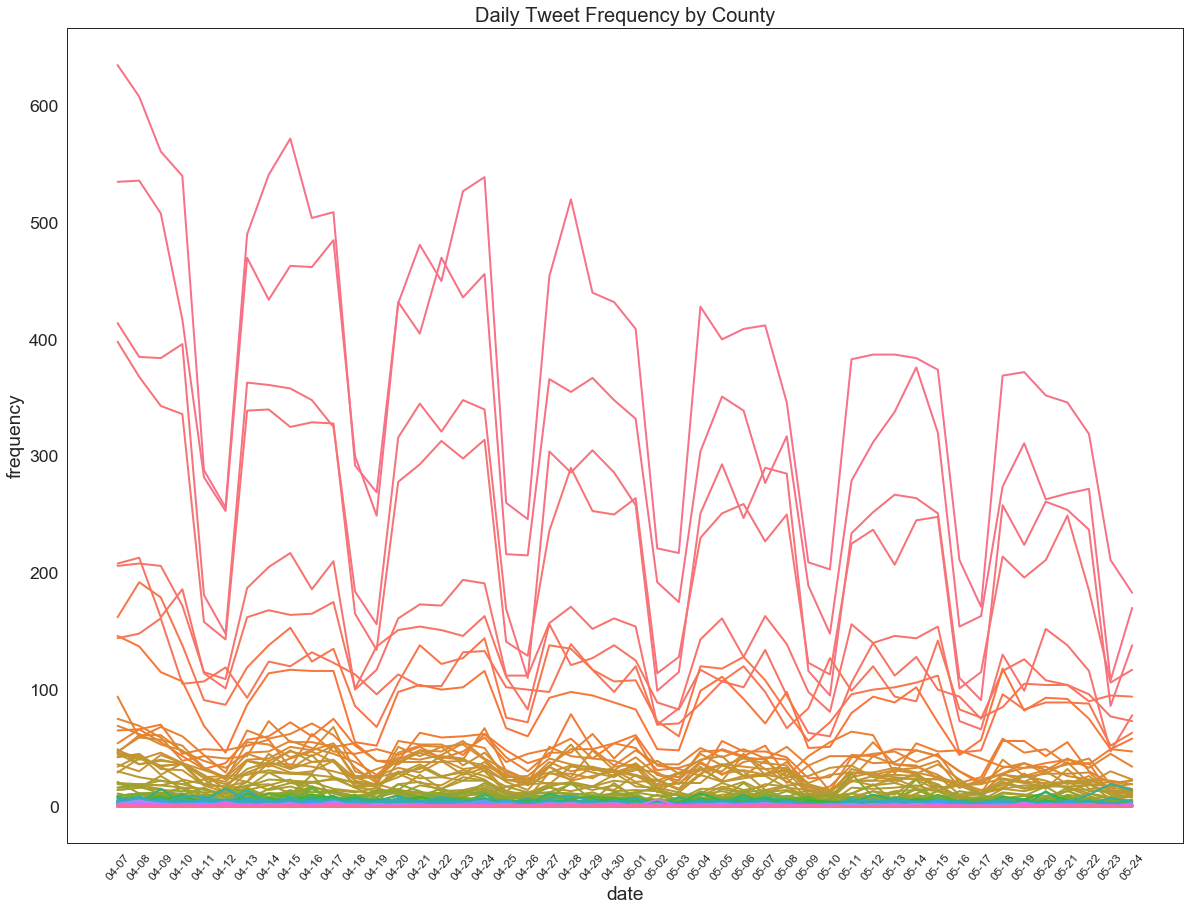

In [961]:
plt.figure(figsize=(20, 15))
ax = sns.lineplot(x="date", y="frequency", hue="county_name", estimator=None, lw=2,
                  data=DTF_long, legend=False)

plt.setp(ax.get_xticklabels(), size=12, rotation=50);
plt.title('Daily Tweet Frequency by County', size=20);
plt.savefig("Daily Tweet Frequency by County", tight_layout=False)

In [962]:
# # Read in old data set
# DTF_long = pd.read_pickle("DTF_long.pickle")
# DTF_long

## Adding statistics to DSS

 - Add overall tweet frequency by county

In [963]:
# Add total number of tweets per county for reference
freqs = pd.DataFrame(merged_cleaned_data.county_name.value_counts())
freqs.reset_index(inplace=True)
freqs.columns=['county_name','NumOfTweets']

In [964]:
DSS = pd.merge(DSS, freqs, on='county_name', how="left")
DSS.head()

,county_name,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,04-15,...,05-16,05-17,05-18,05-19,05-20,05-21,05-22,05-23,05-24,NumOfTweets
0,accomack county,0.210050,-0.233767,NaN,NaN,0.193233,NaN,NaN,0.763900,-0.559000,...,-0.70880,NaN,NaN,0.224400,-0.521500,-0.056200,0.79060,NaN,-0.304300,62
1,albemarle county,0.152820,0.511075,0.476000,0.058267,-0.624900,0.348500,0.197200,0.411033,-0.001775,...,NaN,0.000000,-0.335400,0.000000,0.077200,0.307220,-0.13660,NaN,NaN,130
2,alexandria city,0.099242,0.094447,0.111315,0.090237,-0.000913,0.046577,0.110444,0.117010,0.099704,...,0.06779,0.027501,0.135621,0.120466,0.081155,0.099248,0.11034,0.106803,0.064277,11116
3,alleghany county,NaN,NaN,NaN,0.679200,NaN,-0.526700,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.177900,NaN,NaN,NaN,6
4,amelia county,NaN,NaN,-0.709600,0.431000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,-0.440400,0.612400,NaN,-0.612400,NaN,9


In [965]:
# Drop rows that don't have a sentiment score every day
DSS.dropna(inplace=True)
# Save DSS to folder
DSS.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS.csv")
DSS.to_pickle("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_200516.pickle")
len(DSS)

# Create wide data
DSS_wide = pd.melt(DSS, id_vars=['county_name', 'NumOfTweets'])
DSS_wide.columns=['county_name', 'NumOfTweets','date', 'sent_score']
DSS_wide.to_csv("/Users/rachelmartonik/MSDS_498_Capstone/data/DSS_wide.csv")
DSS_wide.to_pickle("DSS_wide_200516.pickle")

## PCA of Daily Sentiment Score DSS

In [966]:
DSS_for_PCA = DSS.copy()
DSS_for_PCA.set_index('county_name', inplace=True)
DSS_for_PCA.drop(columns='NumOfTweets', inplace=True)
DSS_for_PCA.head()

,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,04-15,04-16,...,05-15,05-16,05-17,05-18,05-19,05-20,05-21,05-22,05-23,05-24
county_name,,,,,,,,,,,,,,,,,,,,,
alexandria city,0.099242,0.094447,0.111315,0.090237,-0.000913,0.046577,0.110444,0.117010,0.099704,0.073425,...,0.165792,0.067790,0.027501,0.135621,0.120466,0.081155,0.099248,0.110340,0.106803,0.064277
arlington county,0.112952,0.091583,0.114026,0.130715,0.028340,0.047672,0.116204,0.145737,0.127005,0.120145,...,0.129550,0.123439,0.115643,0.158987,0.077543,0.048882,0.146787,0.194918,0.071212,0.036388
bedford county,0.136833,-0.054782,-0.079687,0.102470,-0.002750,-0.160787,-0.023064,-0.037687,-0.059507,-0.019862,...,-0.282189,0.073367,0.208040,-0.307750,-0.105750,-0.268567,-0.081140,0.395000,0.000000,-0.038600
bristol city,0.033833,0.444936,0.311230,0.084631,0.038600,-0.590500,0.108033,0.038093,0.046225,0.051912,...,0.080572,0.035957,0.335250,0.095529,0.179500,0.120271,0.222283,0.149009,0.061217,0.348500
charlotte county,0.007176,0.047388,0.044376,0.028057,-0.063068,0.094638,-0.088737,-0.116542,-0.038546,0.020504,...,0.086388,-0.040275,-0.024491,-0.084100,0.149715,0.079253,0.013164,0.141568,-0.072717,0.046545


In [967]:
DSS_for_PCA.dropna(inplace=True)
DSS_for_PCA.head()

,04-07,04-08,04-09,04-10,04-11,04-12,04-13,04-14,04-15,04-16,...,05-15,05-16,05-17,05-18,05-19,05-20,05-21,05-22,05-23,05-24
county_name,,,,,,,,,,,,,,,,,,,,,
alexandria city,0.099242,0.094447,0.111315,0.090237,-0.000913,0.046577,0.110444,0.117010,0.099704,0.073425,...,0.165792,0.067790,0.027501,0.135621,0.120466,0.081155,0.099248,0.110340,0.106803,0.064277
arlington county,0.112952,0.091583,0.114026,0.130715,0.028340,0.047672,0.116204,0.145737,0.127005,0.120145,...,0.129550,0.123439,0.115643,0.158987,0.077543,0.048882,0.146787,0.194918,0.071212,0.036388
bedford county,0.136833,-0.054782,-0.079687,0.102470,-0.002750,-0.160787,-0.023064,-0.037687,-0.059507,-0.019862,...,-0.282189,0.073367,0.208040,-0.307750,-0.105750,-0.268567,-0.081140,0.395000,0.000000,-0.038600
bristol city,0.033833,0.444936,0.311230,0.084631,0.038600,-0.590500,0.108033,0.038093,0.046225,0.051912,...,0.080572,0.035957,0.335250,0.095529,0.179500,0.120271,0.222283,0.149009,0.061217,0.348500
charlotte county,0.007176,0.047388,0.044376,0.028057,-0.063068,0.094638,-0.088737,-0.116542,-0.038546,0.020504,...,0.086388,-0.040275,-0.024491,-0.084100,0.149715,0.079253,0.013164,0.141568,-0.072717,0.046545


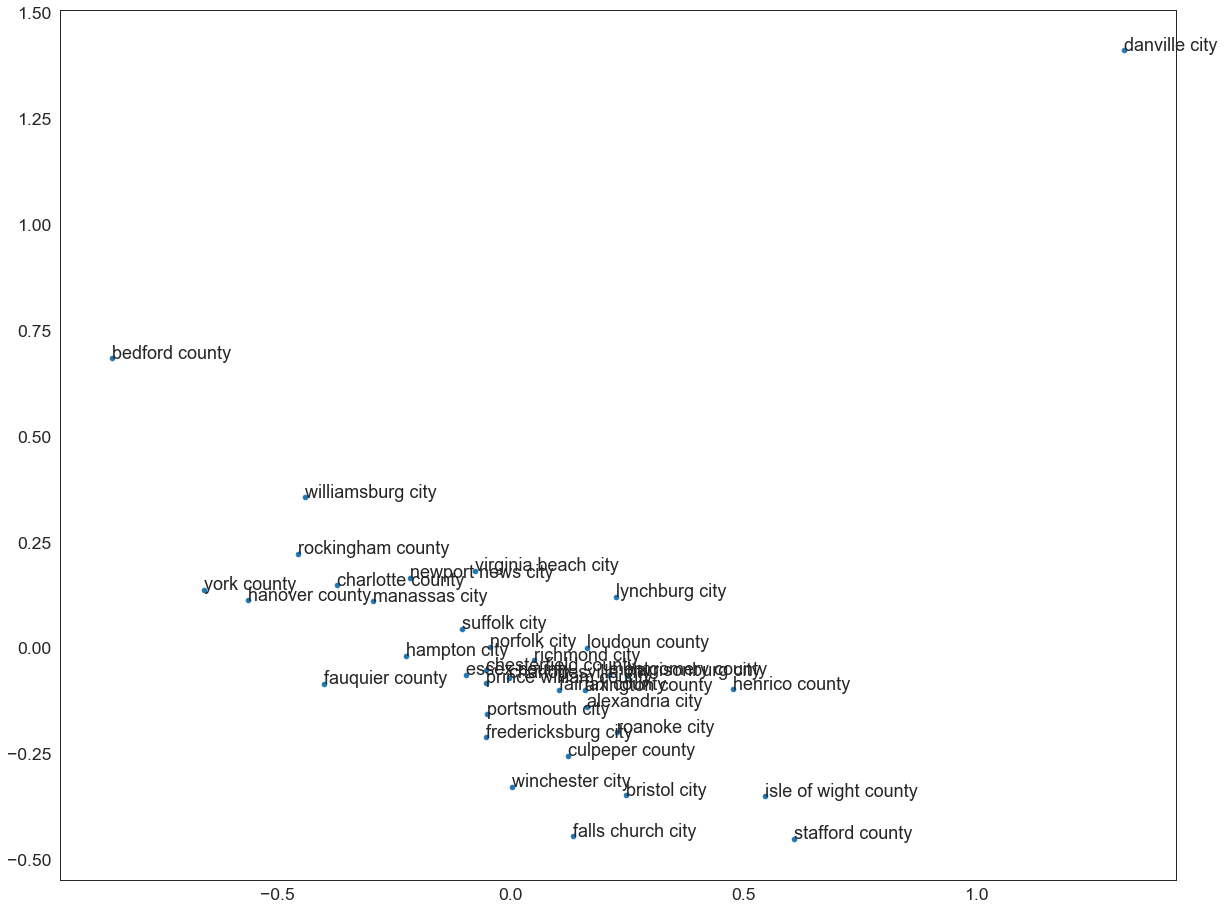

In [968]:
pca = PCA(n_components=2, random_state=RANDOM)
result = pca.fit_transform(DSS_for_PCA)
plt.figure(figsize = (20, 16))
plt.scatter(result[:, 0], result[:, 1])
words = list(DSS_for_PCA.index)
for i, word in enumerate(words):
    plt.annotate(word, size = 18, xy=(result[i, 0], result[i, 1]))
plt.show()

In [261]:
DSS_case_wide =pd.merge(DSS_wide, cases_wide, how='left', left_on=['county_name','date'], right_on=['county_name','date'])
DSS_case_wide

,county_name,NumOfTweets,date,sent_score,cases_per_1000
0,alexandria city,10782,04-07,0.099242,0.805086
1,arlington county,11837,04-07,0.112952,1.022420
2,bedford county,377,04-07,0.136833,0.102685
3,bristol city,435,04-07,0.033833,0.059372
4,charlotte county,953,04-07,0.007176,0.082679
...,...,...,...,...,...
1697,suffolk city,1981,05-22,0.064279,3.174069
1698,virginia beach city,5934,05-22,0.051842,1.312939
1699,williamsburg city,1280,05-22,0.009973,2.907763
1700,winchester city,664,05-22,0.247818,4.354241


In [262]:
cases_wide.head(100)

,county_name,date,cases_per_1000
0,accomack county,04-07,0.335960
1,albemarle county,04-07,0.357294
2,alexandria city,04-07,0.805086
3,alleghany county,04-07,0.130839
4,amelia county,04-07,0.544578
...,...,...,...
95,prince george county,04-07,0.554177
96,prince william county,04-07,0.516695
97,pulaski county,04-07,0.058421
98,radford city,04-07,0.056721


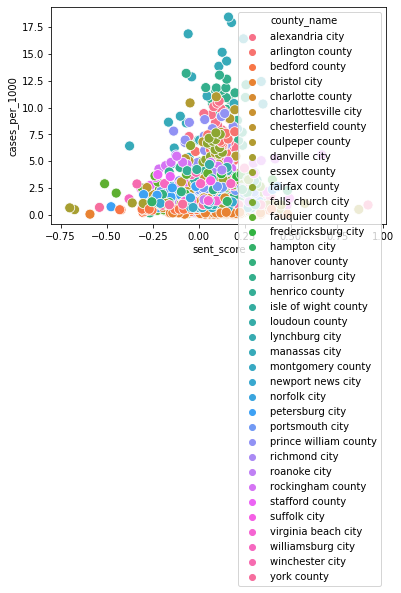

In [263]:
ax = sns.scatterplot(x="sent_score", y="cases_per_1000", hue="county_name",
                     data=DSS_case_wide, s=100 )

# FOR REVIEW = Particular tweets from a county on a specific day

In [264]:
#Bristol took a dip on 4/12
data = data_0412_clean
data = data[data['county_name'] == 'bristol city']
data

,user_id,status_id,created_at,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,...,profile_url,profile_expanded_url,account_lang,profile_banner_url,profile_background_url,profile_image_url,X1,X2,location_cleaned,county_name
14013,x38112802,x1249451322832797696,2020-04-12 21:36:23,AntsWife81515,"The coronavirus spreads at least 13 feet, trav...",Twitter for iPhone,205,NaN,NaN,NaN,...,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/38112802...,http://abs.twimg.com/images/themes/theme10/bg.gif,http://pbs.twimg.com/profile_images/1203189228...,2020-04-12,21:36:23,bristol virginia,bristol city
32163,x4795649800,x1249176647577800704,2020-04-12 03:24:56,Supertalk929,New COVID-19 fatalities reported in region - R...,SuperTalkWFHG.com,79,NaN,NaN,NaN,...,NaN,NaN,NaN,https://pbs.twimg.com/profile_banners/47956498...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/6943385563...,2020-04-12,03:24:56,bristol va,bristol city
32734,x2547728987,x1249164128889028608,2020-04-12 02:35:11,WCYB_Quon,JUST IN: The VA Dept of Health says a resident...,Twitter Web App,109,NaN,NaN,NaN,...,https://t.co/j0PfKKQlXX,https://wcyb.com/station/people/kristen-quon,NaN,https://pbs.twimg.com/profile_banners/25477289...,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1234242731...,2020-04-12,02:35:11,bristol va,bristol city


In [ ]:
# wise county was really high on 4/29
data = data_0429_clean
data = data[data['county_name'] == 'wise county']
data

In [ ]:
# wise county was really high on 4/29
data = data_0415_clean
data = data[data['county_name'] == 'louisa county']
data

# Adding statistics to daily sentiment scores

## COUNTY DATA SETS FOR TIME SERIES ANALYSIS


In [265]:
Manassas_City_sent = DSS_wide[DSS_wide["county_name"]=='manassas city']
Manassas_City_freq = DTF_long[DTF_long["county_name"]=='manassas city']


In [266]:
Manassas_City_sent

,county_name,NumOfTweets,date,sent_score
21,manassas city,797,04-07,-0.041091
58,manassas city,797,04-08,0.140763
95,manassas city,797,04-09,0.204273
132,manassas city,797,04-10,0.134867
169,manassas city,797,04-11,-0.084146
206,manassas city,797,04-12,0.098425
243,manassas city,797,04-13,0.132118
280,manassas city,797,04-14,0.232580
317,manassas city,797,04-15,0.039808
354,manassas city,797,04-16,0.031814
